In [2]:
import numpy as np
import scipy.stats as st
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
mpl.rcParams['font.sans-serif'] = "Helvetica Neue"

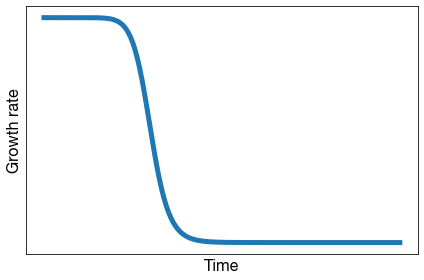

In [15]:
import math
xh = 0.3
b = -10

value = 5.05

def sigmoid(x,p):
    a = np.tan(np.pi/2*xh)**b
    result = p/(a/np.tan(np.pi/2*x)**b+1)
    return result - 0.05

inputs = np.arange(0.001,1,0.001)
sigmoids = np.asarray([sigmoid(i,value) for i in inputs])

fig, ax = plt.subplots(tight_layout = True)

ax.plot(inputs, sigmoids, linewidth=5)
ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("Growth rate",fontsize=16)
#ax.tick_params(axis='both', which='major', labelsize=14)
#ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig("sigmoid.png")

So the goal of this notebook is to build out the mechanics for a longitudinal model of P. falciparum designed off pfLOME. I want to include:
- biting
- tent function
- strain & general immunity

N = number of individuals in population
k = rate of bites/day
y = # of years to simulate
n = number of strains
a = vector of alleles per loci
alpha = general imminity acquisition rate
beta = general immunity loss rate
gamma = strain immunity gain rate
delta = strain immunity loss rate
parasite gone threshold = -3 which, is 0.001

In [16]:
def simulate_bites(y,k):
    '''
    Produces a vector with bite times up until year, y, is reached.

    Time between bites pulled from exponential distribution wih mean rate of k.
    '''
    n = round(y*k*365*2)
    spaces = st.expon.rvs(scale=(1/k), loc=0, size=n)
    times = np.cumsum(spaces)
    trimmed = times[times <= y*365]
    bites = np.ceil(trimmed).astype(int)
    return bites

In [35]:
simulate_bites(5,0.11)

array([   7,    9,   51,   52,   60,   67,   76,   94,  103,  117,  130,
        144,  144,  147,  174,  177,  181,  201,  217,  220,  224,  228,
        239,  243,  247,  248,  249,  256,  277,  296,  316,  325,  337,
        338,  342,  348,  350,  353,  354,  377,  394,  400,  445,  458,
        459,  476,  477,  485,  488,  491,  494,  538,  539,  554,  563,
        568,  569,  590,  600,  618,  642,  654,  656,  657,  661,  674,
        682,  685,  686,  687,  700,  702,  704,  723,  723,  734,  735,
        742,  746,  750,  767,  786,  792,  798,  800,  801,  812,  813,
        821,  829,  838,  838,  848,  855,  875,  877,  883,  885,  893,
        909,  921,  939,  966,  967,  969,  971,  976,  986,  988,  992,
        995,  996, 1005, 1012, 1014, 1037, 1039, 1051, 1051, 1054, 1060,
       1061, 1063, 1069, 1070, 1082, 1090, 1091, 1106, 1130, 1145, 1154,
       1155, 1156, 1160, 1168, 1170, 1214, 1222, 1251, 1263, 1267, 1268,
       1272, 1278, 1279, 1307, 1307, 1309, 1312, 13

In [17]:
def simulate_strains(n,a):
    '''
    n = number of strains to simulate
    a = vector containing whose length corresponds to number of loci.
    Each entry correpsonds to the number of alleles at that loci.
    so a = [3,4,6] will simulate a strain with 3 loci. The first
    loci has 3 alleles; the second loci has 4 alleles, and the third
    loci has 6 alleles.
    
    Returns genotype as a L x n matrix, where L = the number of loci.
    '''
    length = len(a)
    M = np.empty((length,n),dtype=int)
    for i in range(n):
        floats = np.random.rand(length)
        genotype = np.ceil(floats*a)-1
        M[:,i] = genotype
    return M

In [18]:
simulate_strains(5,[3,4,6])

array([[1, 0, 2, 0, 0],
       [2, 2, 2, 0, 0],
       [3, 4, 4, 4, 1]])

In [19]:
def get_infection_params():
    '''
    Generates the duration of infection a geometric distribution.
    Generates starting number of merozoites from a normal distribution.
    Generates growth rate from a distribution.
    Generates parasite max from a distribution.
    '''
    # dur = st.geom.rvs(1/200) This is resulting in way too many short infections
    dur = st.norm.rvs(loc=150,scale=20)
    mz = st.norm.rvs(loc=-2, scale=0.1)
    r = st.norm.rvs(loc=.25, scale=.005) # Unsure what kind of distribution to use here. Maybe log normal? They use log normal distribution for time to peak. Maybe because it can't be negative.
    pmax = st.norm.rvs(loc=5,scale=0.25) # PfLOME uses normal distribution but it stores this variable in log, so I'm going to use a lognormal distribution.
    params = np.array([dur, mz, r, pmax])
    return params
    

In [20]:
param = get_infection_params()

I'm not sure if these are the right params. So I'm going to check them by graphing them.

(array([  3.,   6.,  13.,  37.,  69.,  95., 158., 229., 314., 454., 605.,
        738., 854., 888., 949., 935., 865., 742., 560., 462., 352., 258.,
        184.,  97.,  64.,  40.,  17.,   5.,   4.,   3.]),
 array([4.14016918, 4.1992283 , 4.25828742, 4.31734653, 4.37640565,
        4.43546476, 4.49452388, 4.553583  , 4.61264211, 4.67170123,
        4.73076034, 4.78981946, 4.84887858, 4.90793769, 4.96699681,
        5.02605592, 5.08511504, 5.14417415, 5.20323327, 5.26229239,
        5.3213515 , 5.38041062, 5.43946973, 5.49852885, 5.55758797,
        5.61664708, 5.6757062 , 5.73476531, 5.79382443, 5.85288355,
        5.91194266]),
 <BarContainer object of 30 artists>)

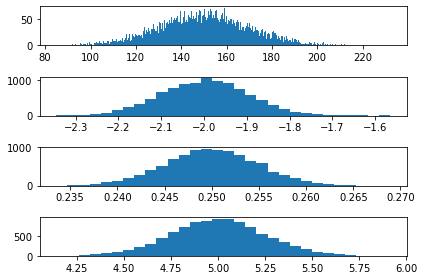

In [21]:
M = np.empty((4,10000))
for i in range(10000):
    M[:,i] = get_infection_params()

fig, axs = plt.subplots(nrows=4, ncols=1, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(M[0,:],bins=500)
axs[1].hist(M[1,:],bins=30)
axs[2].hist(M[2,:],bins=30)
axs[3].hist(M[3,:],bins=30)
    
    

This seems good enough to start. Moving on to the next piece.

I need to calculate daily parasitemia, for the length of the entire infection & then add that in as a vector for each bite.

In [22]:
def create_allele_matrix(a,y):
    '''
    Creates matrix to track parasitemia.
    '''
    length = len(a)
    width = max(a)
    days = 365*y
    M = np.zeros((length,width,days))
    return M

In [23]:
def get_parasitemia(params):
    '''
    Creates parasitemia values distributed according
    to params & adds to parasitemia matrix.
    '''
    dur = params[0].astype(int)
    mz = params[1]
    r = params[2]
    pmax = params[3]
    peaktime = np.rint((pmax - mz)/r).astype(int)
    tpmax = mz + (r*peaktime)
    arr = np.zeros(dur)
    arr[0] = mz
    for i in np.arange(1,peaktime+1):
        arr[i] = arr[i-1] + r
    decline = (-3 - tpmax) / (dur - 1 - peaktime)
    for i in np.arange(peaktime+1,dur):
        arr[i] = arr[i-1] + decline
    return arr

In [24]:
parasitemia = get_parasitemia(param)

In [25]:
parasitemia

array([-1.89543885e+00, -1.65133962e+00, -1.40724038e+00, -1.16314115e+00,
       -9.19041921e-01, -6.74942689e-01, -4.30843457e-01, -1.86744225e-01,
        5.73550073e-02,  3.01454239e-01,  5.45553471e-01,  7.89652703e-01,
        1.03375194e+00,  1.27785117e+00,  1.52195040e+00,  1.76604963e+00,
        2.01014886e+00,  2.25424810e+00,  2.49834733e+00,  2.74244656e+00,
        2.98654579e+00,  3.23064502e+00,  3.47474426e+00,  3.71884349e+00,
        3.96294272e+00,  4.20704195e+00,  4.45114118e+00,  4.69524042e+00,
        4.59530223e+00,  4.49536404e+00,  4.39542585e+00,  4.29548767e+00,
        4.19554948e+00,  4.09561129e+00,  3.99567310e+00,  3.89573492e+00,
        3.79579673e+00,  3.69585854e+00,  3.59592036e+00,  3.49598217e+00,
        3.39604398e+00,  3.29610579e+00,  3.19616761e+00,  3.09622942e+00,
        2.99629123e+00,  2.89635305e+00,  2.79641486e+00,  2.69647667e+00,
        2.59653848e+00,  2.49660030e+00,  2.39666211e+00,  2.29672392e+00,
        2.19678574e+00,  

In [26]:
10**parasitemia

array([1.27221687e-02, 2.23182626e-02, 3.91525106e-02, 6.86845168e-02,
       1.20491963e-01, 2.11376796e-01, 3.70814359e-01, 6.50512693e-01,
       1.14118225e+00, 2.00195467e+00, 3.51199162e+00, 6.16102120e+00,
       1.08081642e+01, 1.89605603e+01, 3.32621563e+01, 5.83511784e+01,
       1.02364381e+02, 1.79575918e+02, 3.15026674e+02, 5.52645400e+02,
       9.69495486e+02, 1.70076779e+03, 2.98362512e+03, 5.23411774e+03,
       9.18211482e+03, 1.61080123e+04, 2.82579846e+04, 4.95724537e+04,
       3.93824045e+04, 3.12870086e+04, 2.48556917e+04, 1.97463880e+04,
       1.56873461e+04, 1.24626756e+04, 9.90086423e+03, 7.86565544e+03,
       6.24880152e+03, 4.96430600e+03, 3.94384970e+03, 3.13315708e+03,
       2.48910938e+03, 1.97745129e+03, 1.57096897e+03, 1.24804263e+03,
       9.91496608e+02, 7.87685853e+02, 6.25770172e+02, 4.97137668e+02,
       3.94946695e+02, 3.13761965e+02, 2.49265463e+02, 1.98026778e+02,
       1.57320651e+02, 1.24982022e+02, 9.92908802e+01, 7.88807758e+01,
      

In [27]:
def add_infection(p,gtype,M,t):
    dur = len(p)
    days = M.shape[2]
    n_alleles = len(gtype)
    for i in np.arange(n_alleles):
        if t+dur >= days:
            dur = days-t
            p = p[:dur]
        M[i,gtype[i],t:t+dur] += 10**p
    
    

In [28]:
parasite_counts = create_allele_matrix([3,4,6],1)

In [29]:
parasite_counts[0,0,0]

0.0

In [30]:
add_infection(parasitemia,[1,2,4],parasite_counts,12)

In [31]:
parasite_counts[2,4,12]

0.012722168733295519

This seems to be working so far. Now I need to simulating parasite counts for an entire infection.

In [32]:
the_alleles = [3,4,6]
bites = simulate_bites(5,0.11)
n_bites = len(bites)
strains = simulate_strains(n_bites,the_alleles)
pmatrix = create_allele_matrix(the_alleles, 5)
    
for i in range(n_bites):
    param = get_infection_params()
    # Add modify based on immunity here
    parasitemia = get_parasitemia(param)
    add_infection(parasitemia,strains[:,i],pmatrix,bites[i])


In [33]:
pmatrix[0,:,:].sum(axis=0).shape

(1825,)

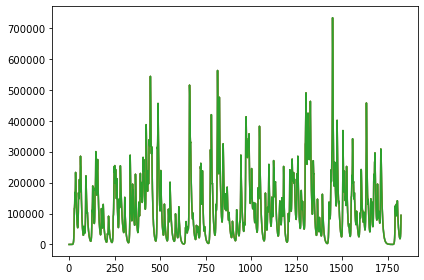

In [34]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.arange(5*365), pmatrix[0,:,:].sum(axis=0))
ax.plot(np.arange(5*365), pmatrix[1,:,:].sum(axis=0))
ax.plot(np.arange(5*365), pmatrix[2,:,:].sum(axis=0))

Looks okay... Need to start developing immunity to bring this down. As max parasitemia values are waayy too high.

Also, I'm just now realizing I don't have a good way to keep track of MOI here....

So, the pfLOME model translates immunity using some sigmoid function. I wanna see how it looks.

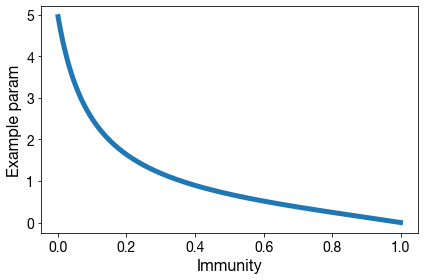

In [3]:
import math
xh = 0.1
b = -1
value = 5

def sigmoid(x,p):
    a = np.tan(np.pi/2*xh)**b
    result = p/(a/np.tan(np.pi/2*x)**b+1)
    return result

inputs = np.arange(0.001,1,0.001)
sigmoids = np.asarray([sigmoid(i,value) for i in inputs])

fig, ax = plt.subplots(tight_layout = True)

ax.plot(inputs, sigmoids, linewidth=5)
ax.set_xlabel("Immunity", fontsize=16)
ax.set_ylabel("Example param",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
#ax.tick_params(axis='both', which='minor', labelsize=8)
fig.savefig("../figs/immunity.pdf")

Okay sigmoid isn't that much different than linear. whatevs. This means that 0 = no immunity, 1 = all the immunity.

I can tweak shape significantly, by changing xh & b above. b controls the extremeness of shape, and xh shifts where the point of inflection is. If b is positive, curve reverses.

In [36]:
def create_gen_imm(y):
    '''
    creates vector for immunity of lenth y *365
    '''
    immunity = np.zeros(y*365)
    return immunity

In [37]:
pmatrix.shape[1]

6

In [48]:
def update_immunity(parasites,t,imm,M,alpha=alpha,beta=beta,gamma=gamma,delta=delta,):
    '''
    If parasitemia present gains immunity. If absent, loses immunity.
    '''
    # General immunity
    
    if parasites[0,:,t].sum(axis=0) > 1:
        if t == 0:
            imm[t] = alpha
        else:
            imm[t] = min(imm[t-1] + alpha,1)
    else:
        if t == 0:
            imm[t] = 0
        else:
            imm[t] = max(imm[t-1] - beta, 0)
        
    # Strain immunity
    loci = parasites.shape[0]
    n_alleles = parasites.shape[1]
    for i in np.arange(loci):
        for j in np.arange(n_alleles):
            if parasites[i,j,t] > 1:
                if t == 0:
                    M[i,j,t] = gamma
                else:
                    M[i,j,t] = min(M[i,j,t-1] + gamma,1)
            else:
                if t == 0:
                    M[i,j,t] = 0
                else:
                    M[i,j,t] = max(M[i,j,t-1] - delta, 0)

In [39]:
alpha = 1/500
beta = 1/500
gamma = 1/365
delta = 1/365

In [51]:
the_alleles = [3,4,6]
bites = simulate_bites(5,0.11)
n_bites = len(bites)
strains = simulate_strains(n_bites,the_alleles)
pmatrix = create_allele_matrix(the_alleles, 5)
imatrix = create_allele_matrix(the_alleles,5)
ivector = create_gen_imm(5)

counter = 0
for t in range(365*5):
    update_immunity(pmatrix,t,ivector,imatrix)
    if t in bites:
        param = get_infection_params()
        # Add modify based on immunity here
        parasitemia = get_parasitemia(param)
        add_infection(parasitemia,strains[:,counter],pmatrix,bites[counter])
        counter += 1


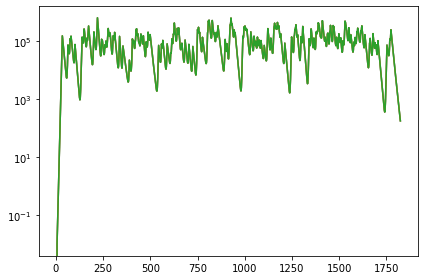

In [52]:
fig, ax = plt.subplots(tight_layout=True)
ax.set_yscale('log')
ax.plot(np.arange(5*365), pmatrix[0,:,:].sum(axis=0))
ax.plot(np.arange(5*365), pmatrix[1,:,:].sum(axis=0))
ax.plot(np.arange(5*365), pmatrix[2,:,:].sum(axis=0))

In [53]:
ivector

array([0.   , 0.   , 0.   , ..., 0.828, 0.83 , 0.832])

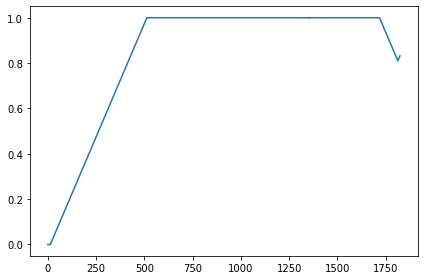

In [54]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.arange(5*365), ivector)

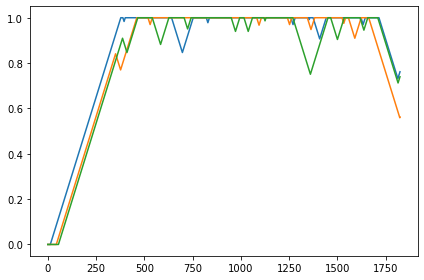

In [55]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.arange(5*365), imatrix[0,0,:])
ax.plot(np.arange(5*365), imatrix[0,1,:])
ax.plot(np.arange(5*365), imatrix[0,2,:])

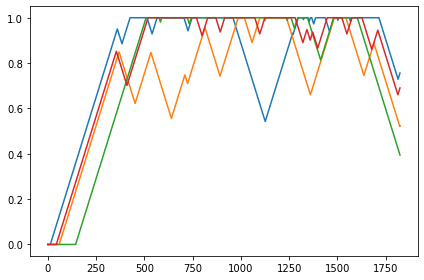

In [56]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.arange(5*365), imatrix[1,0,:])
ax.plot(np.arange(5*365), imatrix[1,1,:])
ax.plot(np.arange(5*365), imatrix[1,2,:])
ax.plot(np.arange(5*365), imatrix[1,3,:])

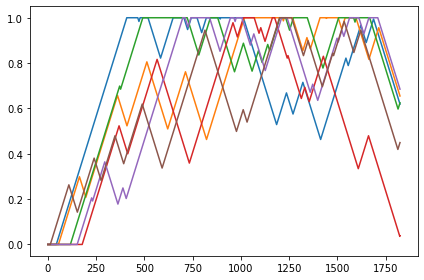

In [57]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.arange(5*365), imatrix[2,0,:])
ax.plot(np.arange(5*365), imatrix[2,1,:])
ax.plot(np.arange(5*365), imatrix[2,2,:])
ax.plot(np.arange(5*365), imatrix[2,3,:])
ax.plot(np.arange(5*365), imatrix[2,4,:])
ax.plot(np.arange(5*365), imatrix[2,5,:])

So now I have to figure out how immunity is coded in PfLOME

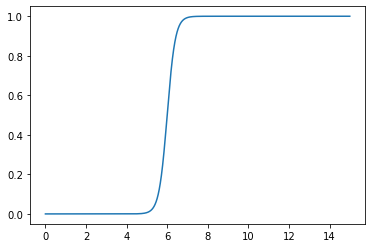

In [3]:
def sigmoidX(X, X50=6, Xs=5, atMax=11):
    result = np.minimum((1/(1+np.exp(-Xs*(X-X50))) - 1/(1+np.exp(Xs*X50)))/(1/(1+np.exp(-Xs*(atMax-X50))) - 1/(1+np.exp(Xs*X50))),1)
    return result

x = np.arange(0.001,15,0.001)
fig, ax = plt.subplots()
ax.plot(x, sigmoidX(x))
    
                         

So this just basically says that if parasitemia is over 6, K = 1.

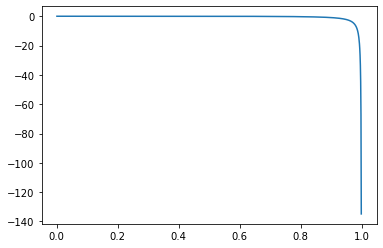

In [10]:
def change_immunity(x):
    value = 1/(1-np.exp(np.exp(2)*np.abs(1-x)))
    return value

x = np.arange(0.001,1,0.001)


fig,ax = plt.subplots()
ax.plot(x,change_immunity(x))

So basically when immunity gets really high, it decreases by a lot. Or basically, immunity can never get above 1.

Soo I think solved the immunity deal. It's not nice & curved like PfLOME, but should do the trick. Now I need to weight each type of immunity & use it to modulate infection params. I'll use the initial sigmoid curve as a starting place.

In [283]:
def modulate_params(imm, params):
    '''
    Changes infection params according to immunity
    '''
    return sigmoid(imm, params)


In [61]:
the_alleles = [3,4,6]
bites = simulate_bites(5,0.11)
n_bites = len(bites)
strains = simulate_strains(n_bites,the_alleles)
pmatrix = create_allele_matrix(the_alleles, 5)
imatrix = create_allele_matrix(the_alleles,5)
ivector = create_gen_imm(5)

counter = 0
for t in range(365*5):
    update_immunity(pmatrix,t,ivector,imatrix)
    if t in bites:
        initial = get_infection_params()
        modified = sigmoid(ivector[t], initial)
        # Add modify based on immunity here
        parasitemia = get_parasitemia(modified)
        add_infection(parasitemia,strains[:,counter],pmatrix,bites[counter])
        counter += 1


/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_44306/2581726040.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  result = p/(a/np.tan(np.pi/2*x)**b+1)
/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_44306/23457448.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  decline = (-3 - tpmax) / (dur - 1 - peaktime)


IndexError: index 26 is out of bounds for axis 0 with size 26

In [67]:
param = get_infection_params()

modified = modulate_params(0.8,param)

peaktime = np.rint((modified[3] - modified[1])/modified[2]).astype(int)

print(param)

print(modified)

print(peaktime)

[167.84956681  -1.98997737   0.25748283   5.31252232]
[41.16297042 -0.48801663  0.06314439  1.3028285 ]
28


Ahh, so this is why. They don't modify growth rate. You end up with a tent that's shaped differently. OK. How should I ensure peaktime is below duration or should I just shorten time to peak instead?? I'll do what PfLOME did and rather than chagne growth rates. I'll change params.

In [382]:
def get_infection_params():
    '''
    Generates the duration of infection a geometric distribution.
    Generates starting number of merozoites from a normal distribution.
    Generates time to peak from a distribution.
    Generates parasite max from a distribution.
    '''
    #dur = st.geom.rvs(1/200) #This is resulting in way too much variability
    dur = np.rint(st.norm.rvs(loc=150,scale=20))
    mz = st.norm.rvs(loc=0.01, scale=0.005)
    peaktime = np.rint(st.norm.rvs(loc=20, scale=3)) # Unsure what kind of distribution to use here. Maybe log normal? They use log normal distribution for time to peak. Maybe because it can't be negative.
    #peaktime = st.geom.rvs(1/20)
    pmax = st.norm.rvs(loc=6,scale=0.25) # PfLOME uses normal distribution but it stores this variable in log, so I'm going to use a lognormal distribution.
    params = np.array([dur, mz, peaktime, pmax])
    return params


def get_parasitemia(params):
    '''
    Creates parasitemia values distributed according
    to params & adds to parasitemia matrix.
    '''
    dur = params[0].astype(int)
    mz = params[1]
    peaktime = params[2].astype(int)
    pmax = params[3]
    gr = (pmax - mz)/peaktime
    dr = (-3 - pmax) / (dur - peaktime - 1)
    arr = np.zeros(dur)
    arr[0] = mz
    for i in np.arange(1,peaktime+1):
        arr[i] = arr[i-1] + gr
    for i in np.arange(peaktime+1,dur):
        arr[i] = arr[i-1] + dr
    return arr
    

In [141]:
param = get_infection_params()
print(param)
get_parasitemia(param)

[169.          -1.92938767  19.           4.83096365]


array([-1.92938767e+00, -1.57357971e+00, -1.21777175e+00, -8.61963781e-01,
       -5.06155816e-01, -1.50347852e-01,  2.05460113e-01,  5.61268078e-01,
        9.17076042e-01,  1.27288401e+00,  1.62869197e+00,  1.98449994e+00,
        2.34030790e+00,  2.69611587e+00,  3.05192383e+00,  3.40773179e+00,
        3.76353976e+00,  4.11934772e+00,  4.47515569e+00,  4.83096365e+00,
        4.77840685e+00,  4.72585005e+00,  4.67329324e+00,  4.62073644e+00,
        4.56817964e+00,  4.51562283e+00,  4.46306603e+00,  4.41050923e+00,
        4.35795243e+00,  4.30539562e+00,  4.25283882e+00,  4.20028202e+00,
        4.14772521e+00,  4.09516841e+00,  4.04261161e+00,  3.99005480e+00,
        3.93749800e+00,  3.88494120e+00,  3.83238440e+00,  3.77982759e+00,
        3.72727079e+00,  3.67471399e+00,  3.62215718e+00,  3.56960038e+00,
        3.51704358e+00,  3.46448677e+00,  3.41192997e+00,  3.35937317e+00,
        3.30681636e+00,  3.25425956e+00,  3.20170276e+00,  3.14914596e+00,
        3.09658915e+00,  

In [359]:
alpha = 1/500
beta = 1/500
gamma = 1/100
delta = 1/500

In [209]:
def add_infection(p,gtype,M,t):
    dur = len(p)
    days = M.shape[2]
    n_alleles = len(gtype)
    for i in np.arange(n_alleles):
        if t+dur >= days:
            dur = days-t
            p = p[:dur]
        M[i,gtype[i],t:t+dur] += 10**p
    

In [360]:
def update_immunity(parasites,t,imm,M,alpha=alpha,beta=beta,gamma=gamma,delta=delta,):
    '''
    If parasitemia present gains immunity. If absent, loses immunity.
    '''
    # General immunity
    
    if parasites[0,:,t].sum(axis=0) > 1:
        if t == 0:
            imm[t] = alpha
        else:
            imm[t] = min(imm[t-1] + alpha,1)
    else:
        if t == 0:
            imm[t] = 0
        else:
            imm[t] = max(imm[t-1] - beta, 0)
        
    # Strain immunity
    loci = parasites.shape[0]
    n_alleles = parasites.shape[1]
    for i in np.arange(loci):
        for j in np.arange(n_alleles):
            if parasites[i,j,t] > 1:
                if t == 0:
                    M[i,j,t] = gamma
                else:
                    M[i,j,t] = min(M[i,j,t-1] + gamma,1)
            else:
                if t == 0:
                    M[i,j,t] = 0
                else:
                    M[i,j,t] = max(M[i,j,t-1] - delta, 0)

In [258]:
the_alleles = [3,4,6]
bites = simulate_bites(5,0.11)
n_bites = len(bites)
strains = simulate_strains(n_bites,the_alleles)
pmatrix = create_allele_matrix(the_alleles, 5)
imatrix = create_allele_matrix(the_alleles,5)
ivector = create_gen_imm(5)

counter = 0
for t in range(365*5):
    update_immunity(pmatrix,t,ivector,imatrix)
    if t in bites:
        locs = np.where(bites == t)
        for i in locs[0]:
            params = get_infection_params()
            if ivector[t] != 0:
                params = sigmoid(ivector[t], params)
            # Add modify based on immunity here
            parasitemia = get_parasitemia(params)
            add_infection(parasitemia,strains[:,i],pmatrix,bites[i])


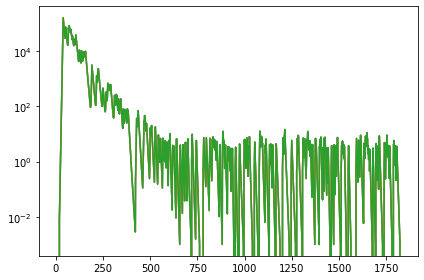

In [259]:
fig, ax = plt.subplots(tight_layout=True)
ax.set_yscale('log')
ax.plot(np.arange(5*365), pmatrix[0,:,:].sum(axis=0))
ax.plot(np.arange(5*365), pmatrix[1,:,:].sum(axis=0))
ax.plot(np.arange(5*365), pmatrix[2,:,:].sum(axis=0))


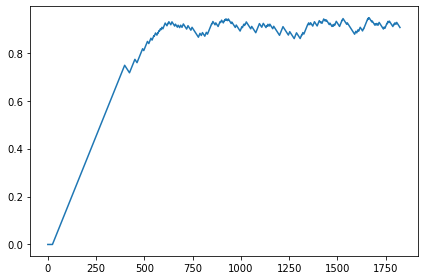

In [260]:
fig,ax = plt.subplots(tight_layout=True)
ax.plot(np.arange(5*365), ivector)

So densities recorded are NOT the same as the densities immunity is being developed to... why?

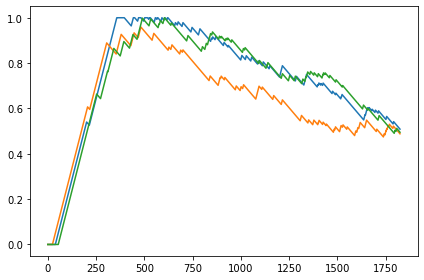

In [261]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.arange(5*365), imatrix[0,0,:])
ax.plot(np.arange(5*365), imatrix[0,1,:])
ax.plot(np.arange(5*365), imatrix[0,2,:])

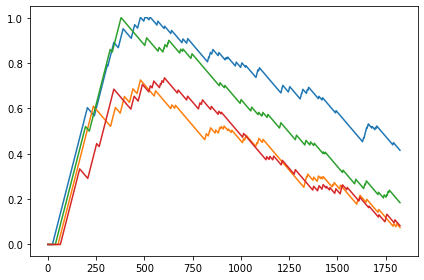

In [262]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.arange(5*365), imatrix[1,0,:])
ax.plot(np.arange(5*365), imatrix[1,1,:])
ax.plot(np.arange(5*365), imatrix[1,2,:])
ax.plot(np.arange(5*365), imatrix[1,3,:])

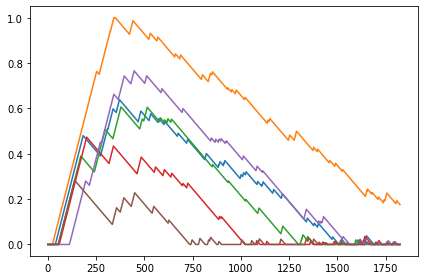

In [263]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.arange(5*365), imatrix[2,0,:])
ax.plot(np.arange(5*365), imatrix[2,1,:])
ax.plot(np.arange(5*365), imatrix[2,2,:])
ax.plot(np.arange(5*365), imatrix[2,3,:])
ax.plot(np.arange(5*365), imatrix[2,4,:])
ax.plot(np.arange(5*365), imatrix[2,5,:])

OKay, general immunity seems to be working...now for strain specific immunity.

In [295]:
def modulate_params(gen_imm, strain_imm, gtype, w, params):
    '''
    Changes infection params according to immunity
    '''
    n_loci = len(gtype)
    cross = np.empty(n_loci)
    for i in np.arange(n_loci):
        allele = gtype[i]
        cross[i] = strain_imm[i,allele]
    imm = np.append(gen_imm, cross)
    
    M = np.zeros((4, n_loci+1))
    for i, p in enumerate(params):
        for j, v in enumerate(imm):
            if v == 0:
                M[i,j] = p*w[j]
            else:
                M[i,j] = sigmoid(v, p*w[j])
    modified = np.zeros(4)
    for i in np.arange(4):
        modified[i] = M[i,:].sum()
    
    return modified

In [293]:
imatrix = np.zeros((3,6))
imatrix[0,0] = 0.1
imatrix[0,1] = 0.2
imatrix[0,2] = 0.3
imatrix[1,0] = 0.3
imatrix[1,1] = 0.1
imatrix[1,2] = 0.2
imatrix[1,3] = 0.4
imatrix[2,0] = 0.1
imatrix[2,1] = 0.1
imatrix[2,2] = 0.1
imatrix[2,3] = 0.1
imatrix[2,4] = 0.1
imatrix[2,5] = 0.1



modified = modulate_params(0.6, imatrix, [2,3,5], [0.1, 0.3, 0.3, 0.3], param)
print(param)
print(modified)

[169.          -1.92938767  19.           4.83096365]
[113.83126443  -1.29955407  12.79759778   3.25393314]


In [422]:
weight = [0,.2,.1,.2,.05,.1,.05,.1,.07,.03,.1,0]
the_alleles = [3,4,6,5,5,6,5,7,8,9,5]
bites = simulate_bites(3,0.11)
n_bites = len(bites)
strains = simulate_strains(n_bites,the_alleles)
pmatrix = create_allele_matrix(the_alleles, 3)
imatrix = create_allele_matrix(the_alleles,3)
ivector = create_gen_imm(3)

counter = 0
for t in range(365*3):
    update_immunity(pmatrix,t,ivector,imatrix)
    if t in bites:
        locs = np.where(bites == t)
        for i in locs[0]:
            params = get_infection_params()
            params = modulate_params(ivector[t], imatrix[:,:,t], strains[:,1], weight, params)
            # Add modify based on immunity here
            parasitemia = get_parasitemia(params)
            add_infection(parasitemia,strains[:,i],pmatrix,bites[i])

(1, 3000000)

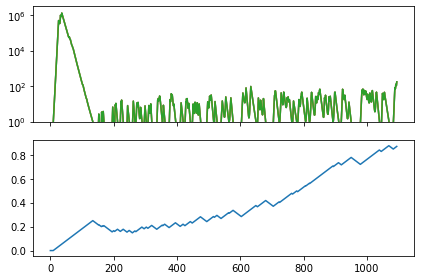

In [423]:
fig, ax = plt.subplots(nrows=2, sharex=True, tight_layout=True)
ax[0].set_yscale('log')
ax[0].plot(np.arange(3*365), pmatrix[0,:,:].sum(axis=0))
ax[0].plot(np.arange(3*365), pmatrix[1,:,:].sum(axis=0))
ax[0].plot(np.arange(3*365), pmatrix[2,:,:].sum(axis=0))
ax[1].plot(np.arange(3*365), ivector)
ax[0].set_ylim(1,3000000)


/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_44306/1413068339.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = (16,4), tight_layout=True)


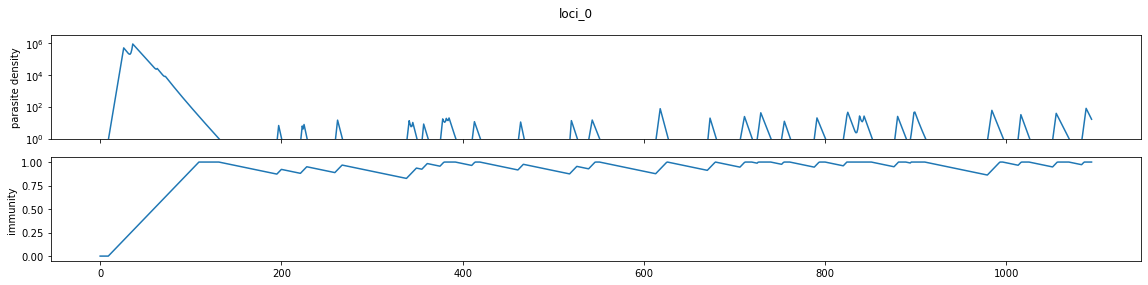

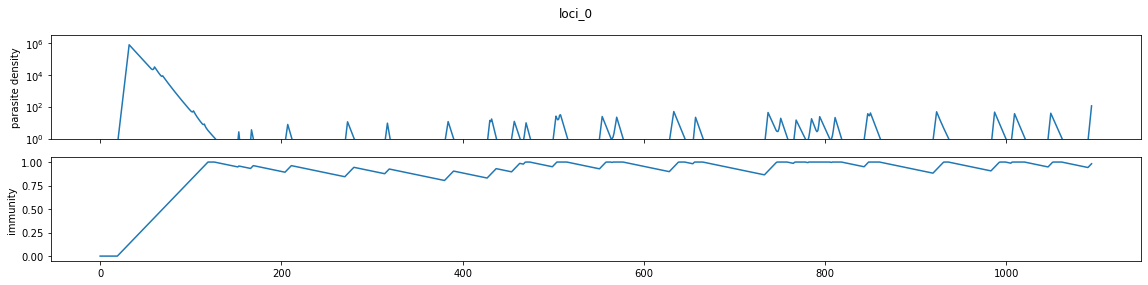

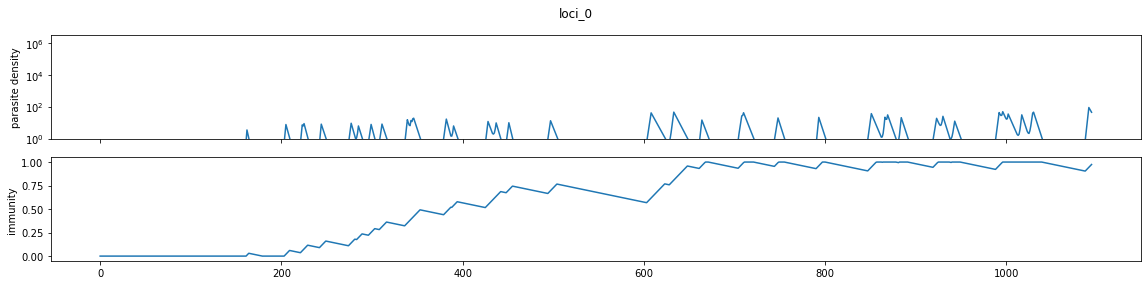

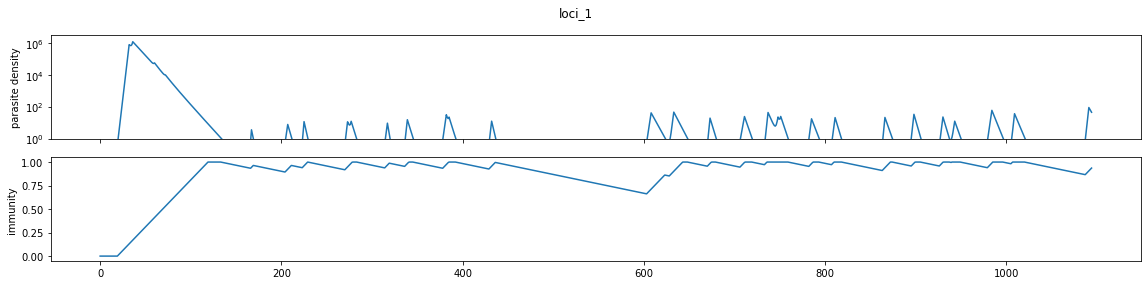

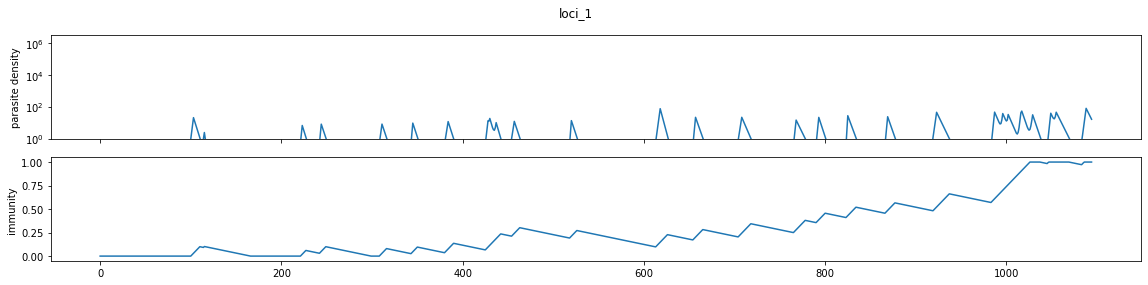

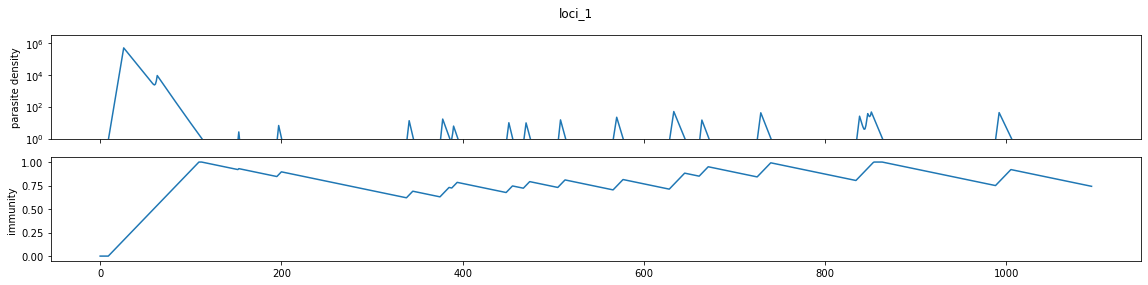

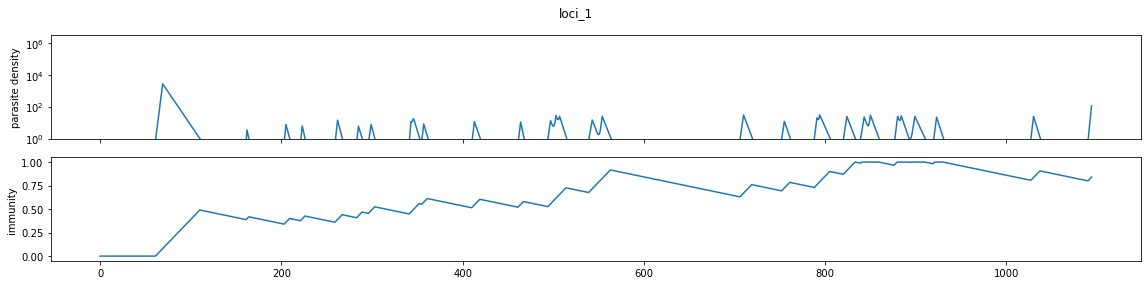

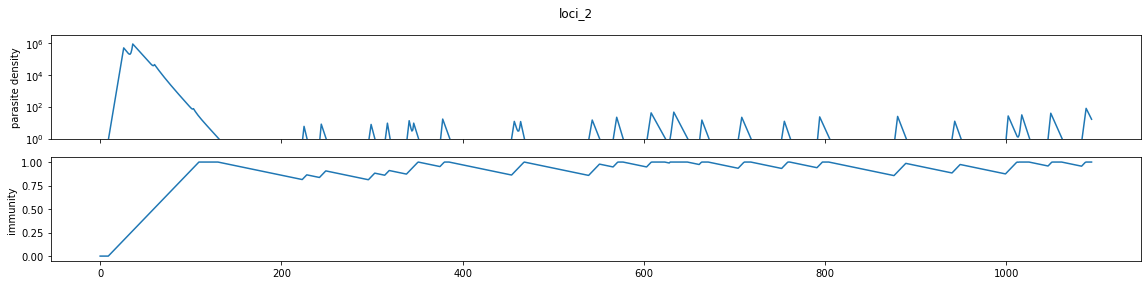

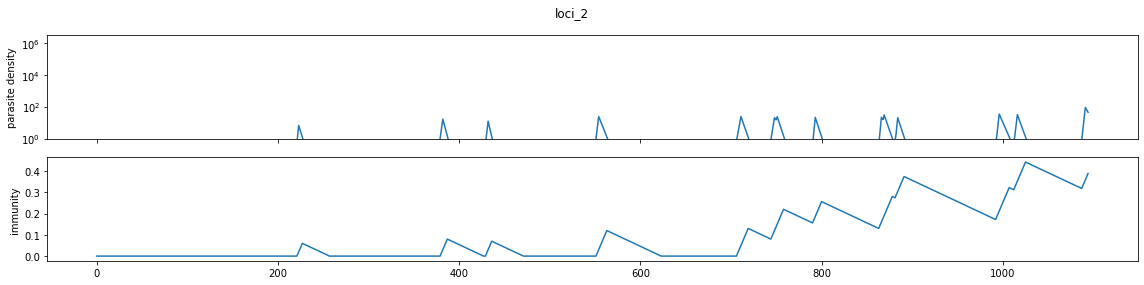

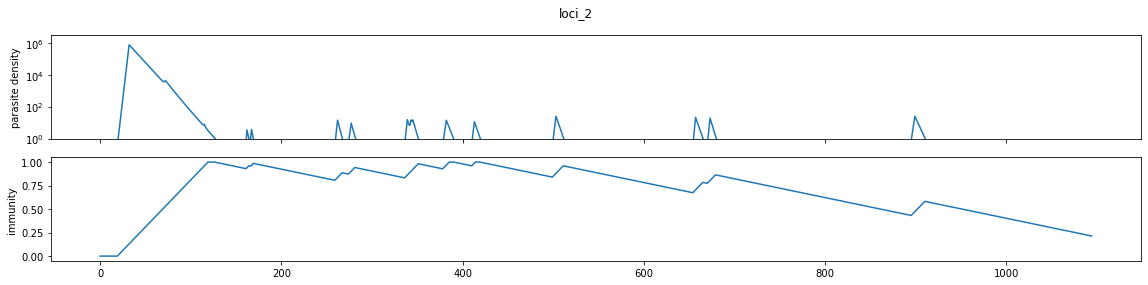

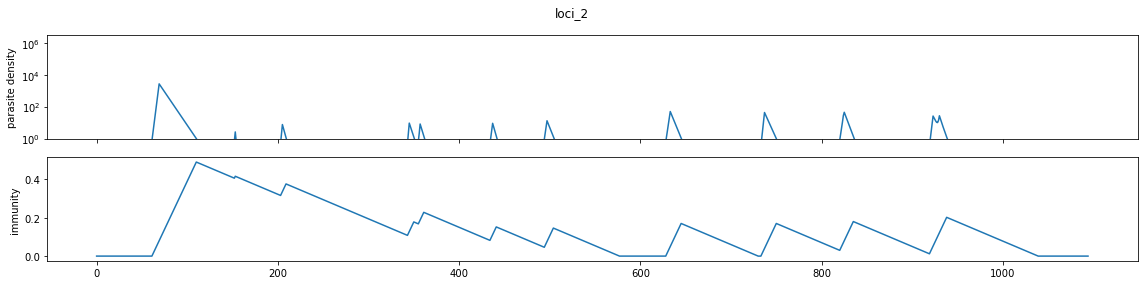

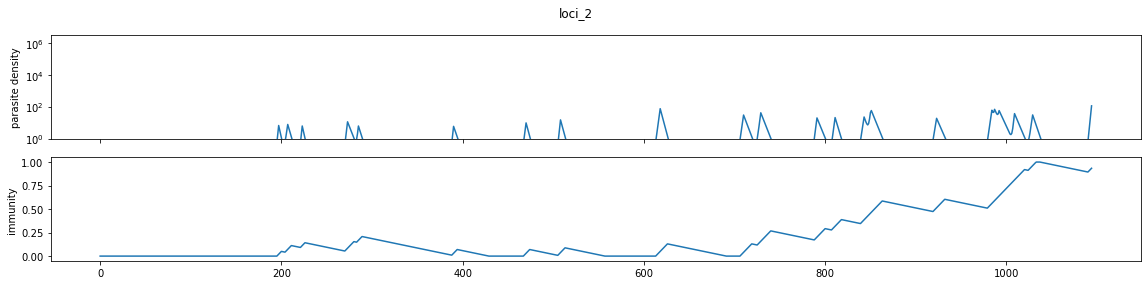

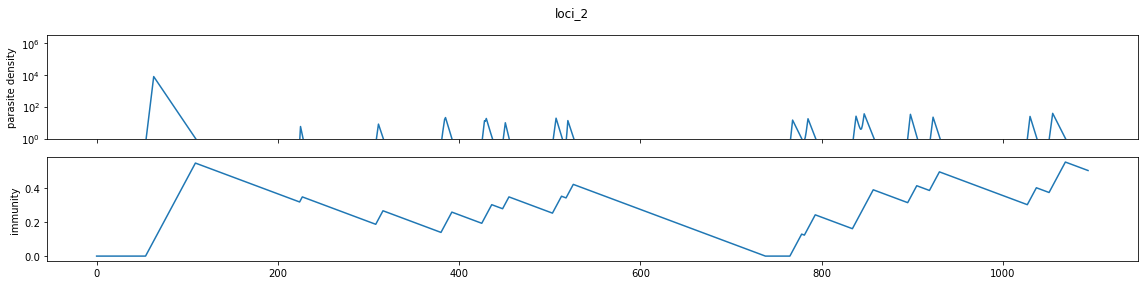

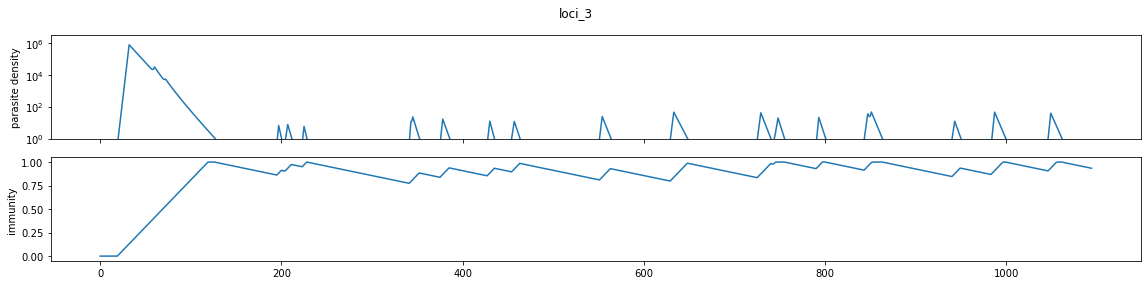

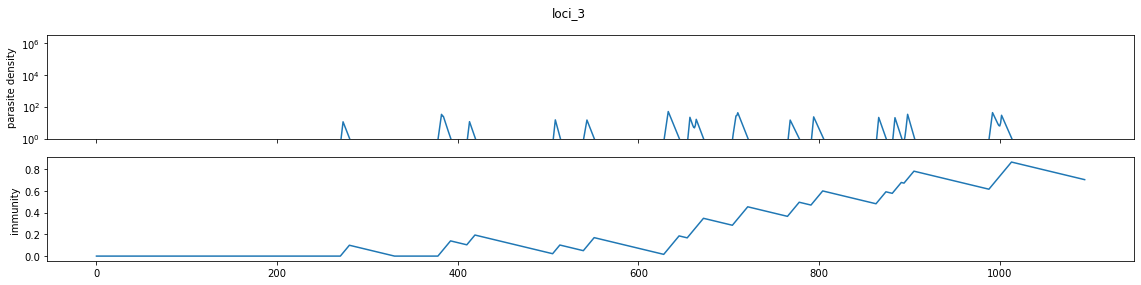

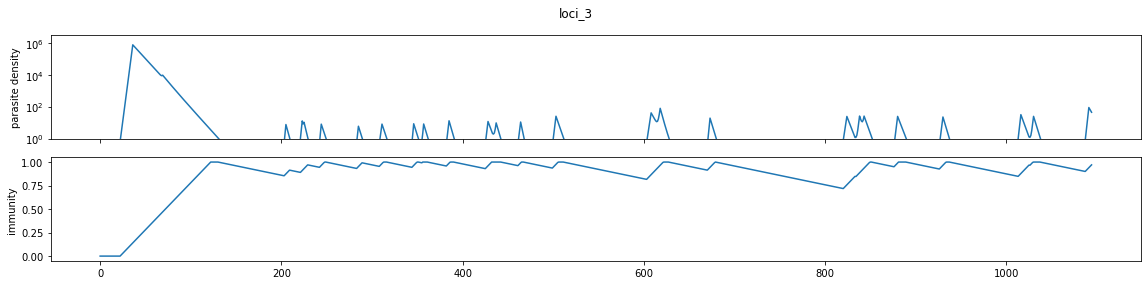

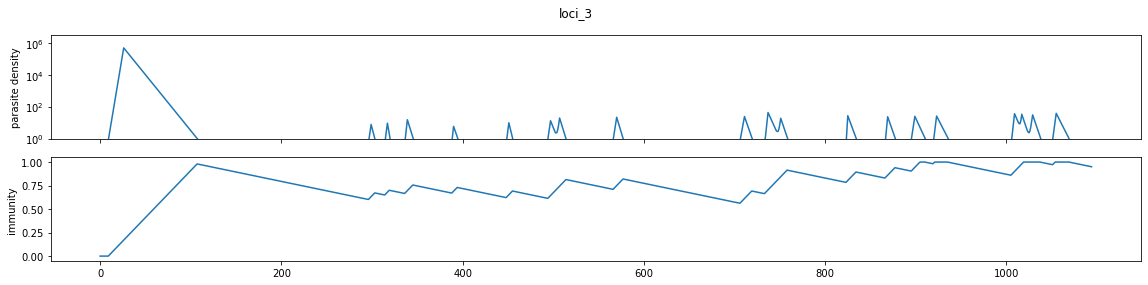

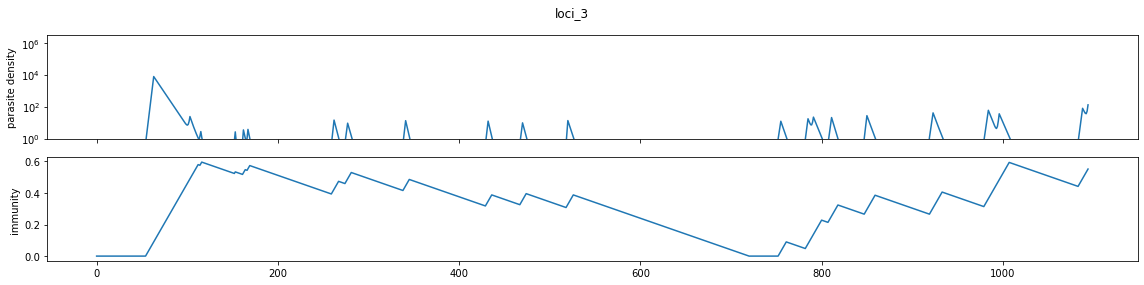

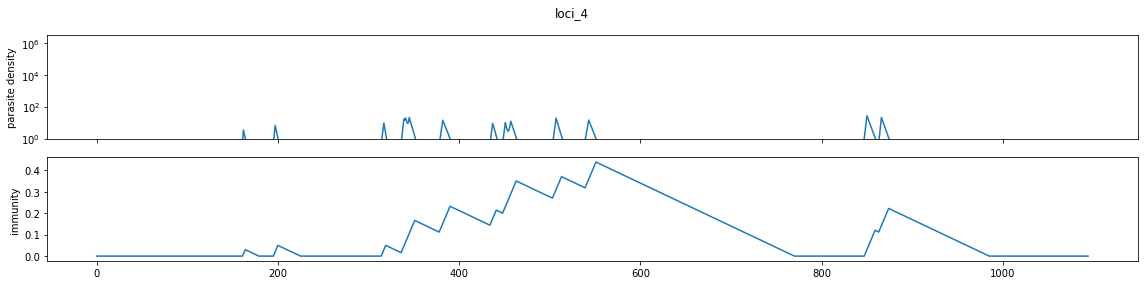

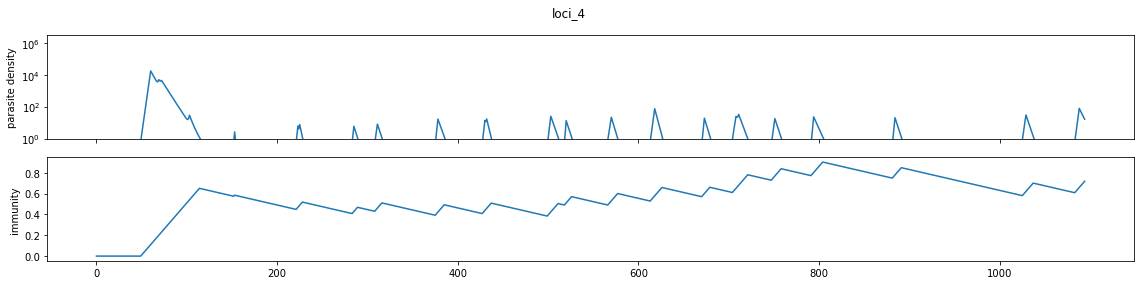

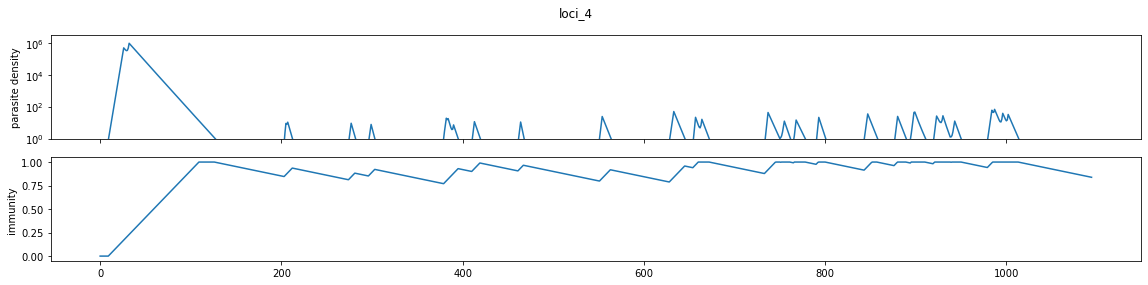

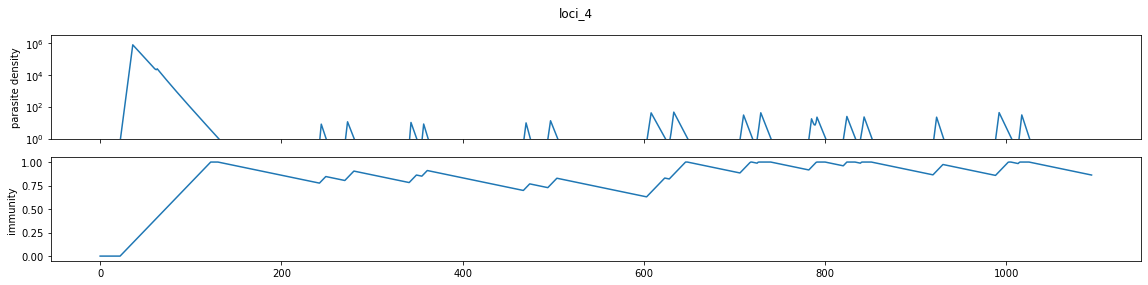

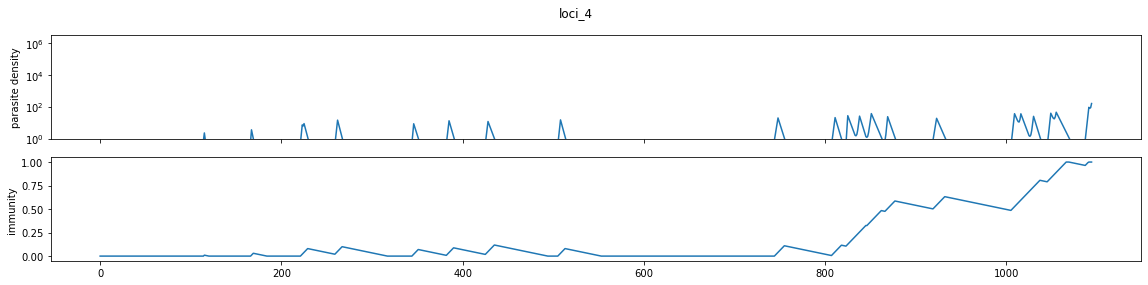

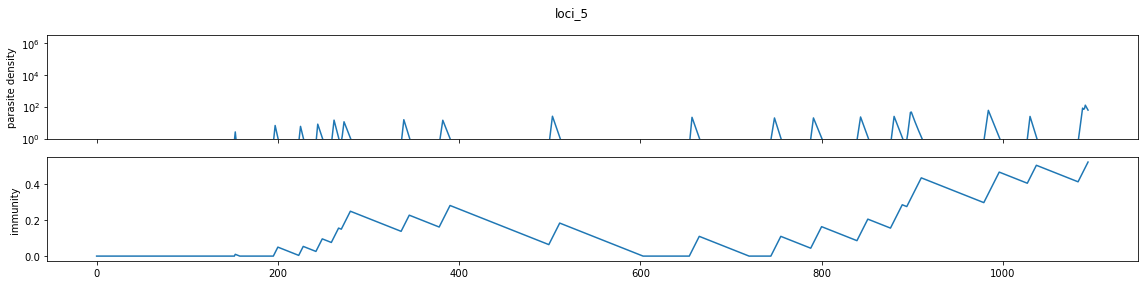

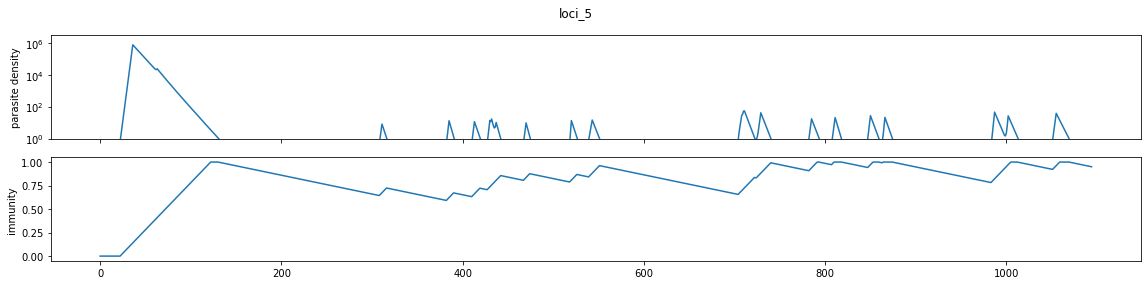

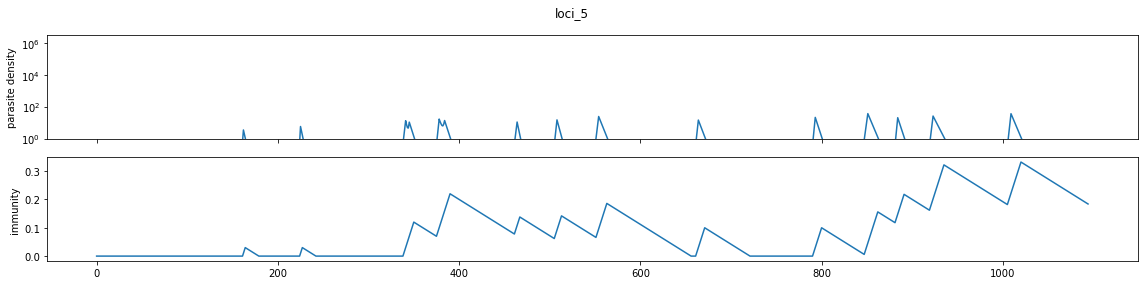

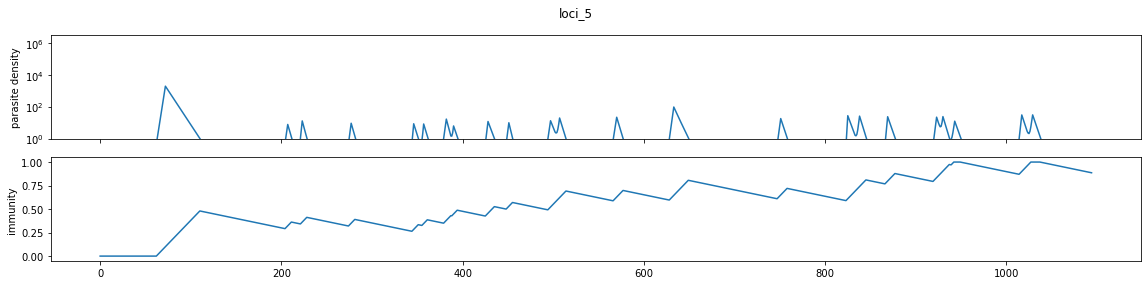

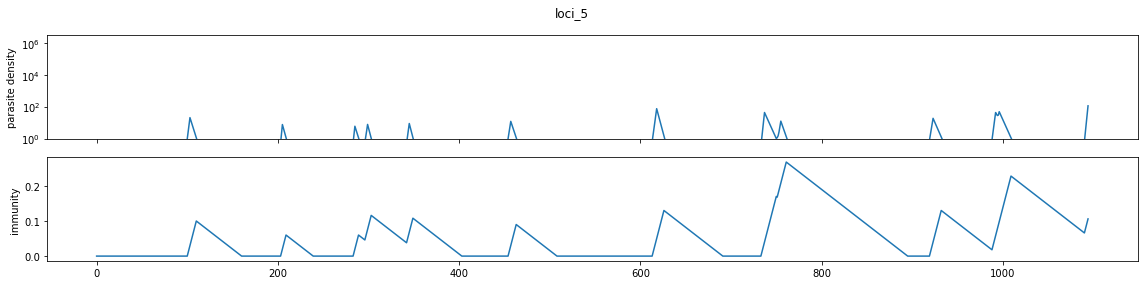

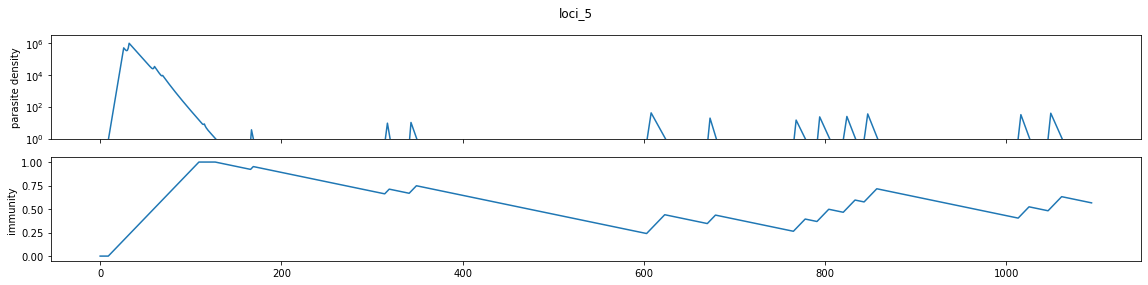

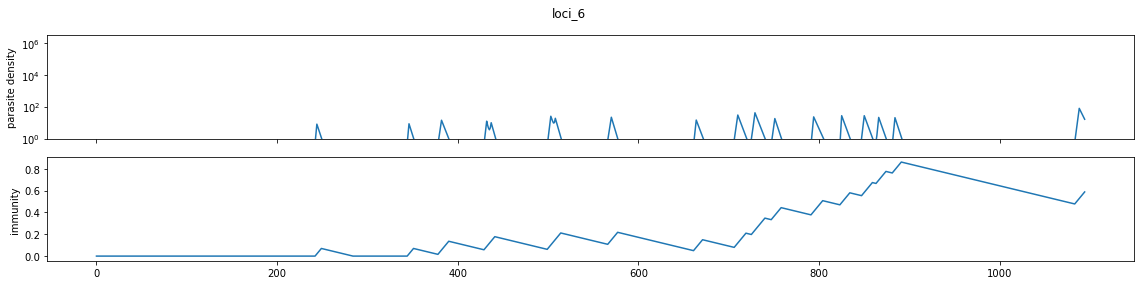

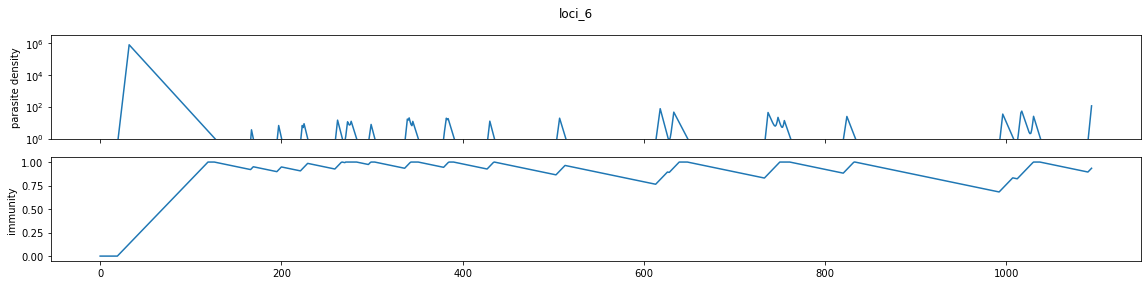

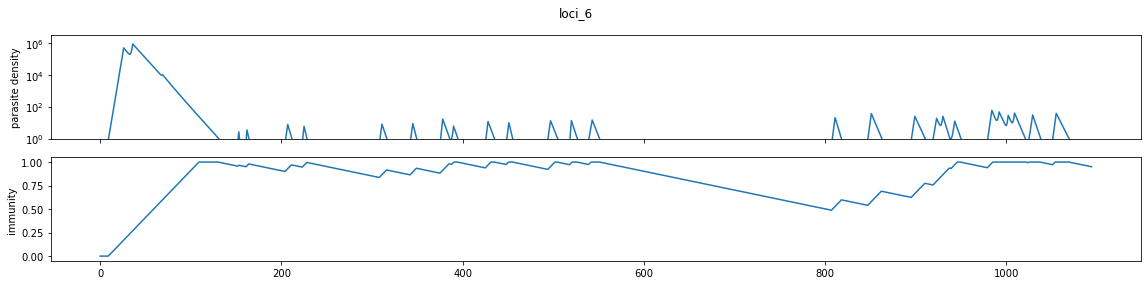

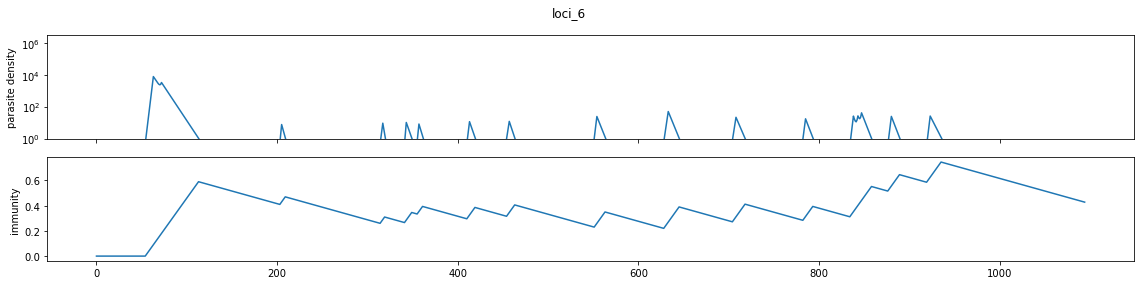

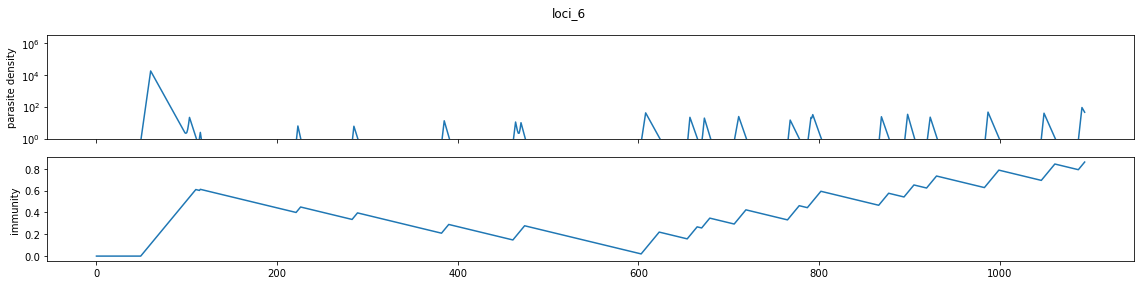

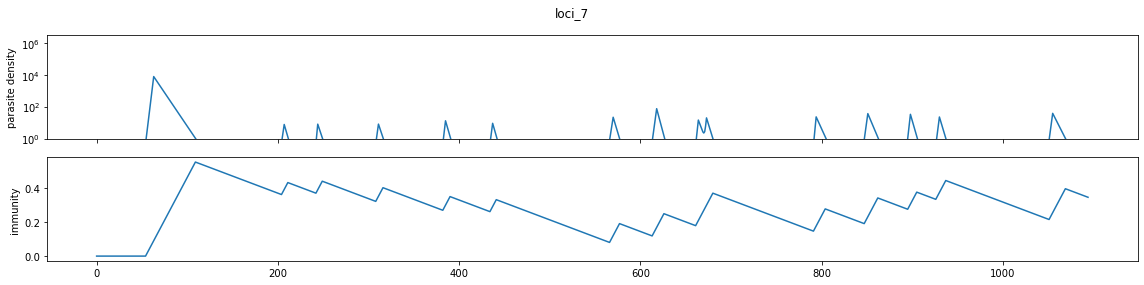

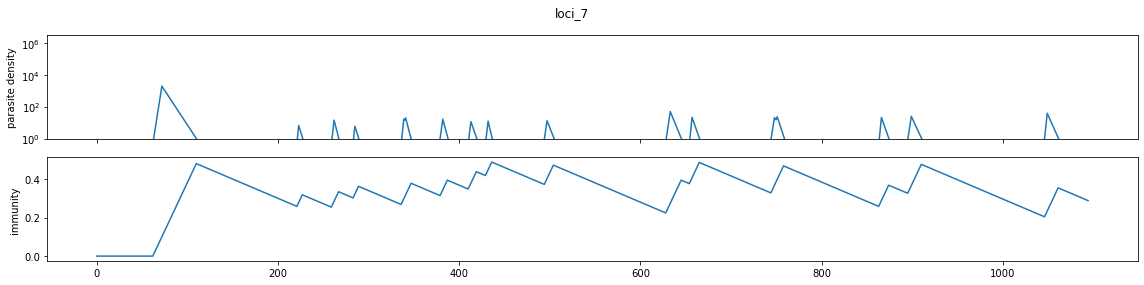

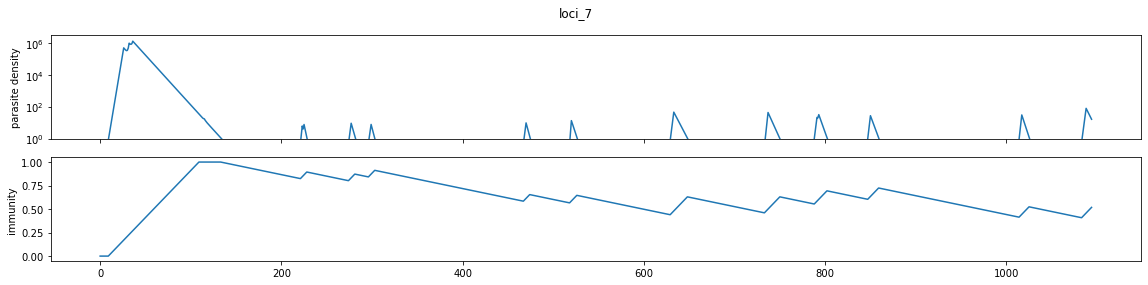

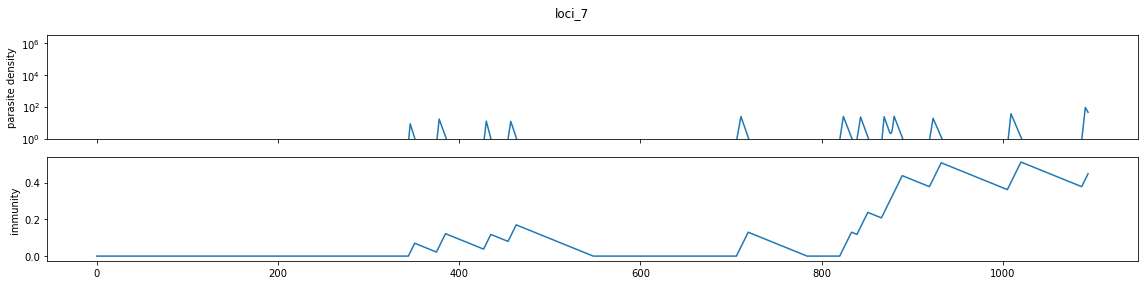

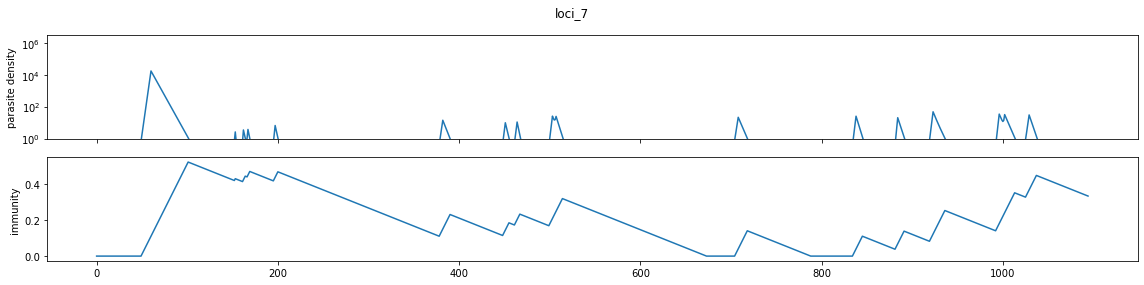

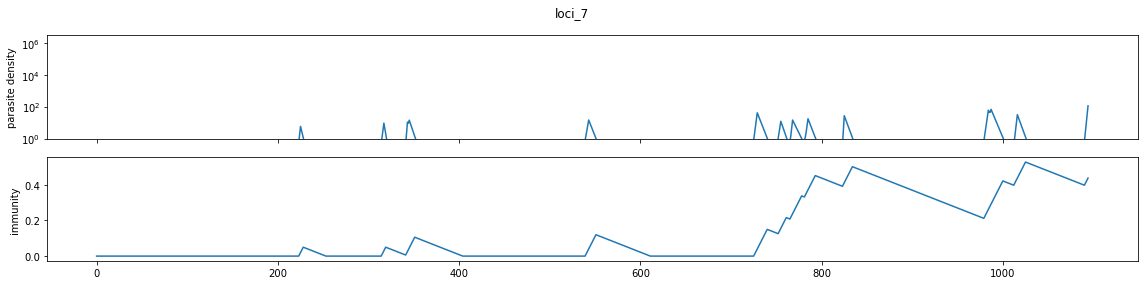

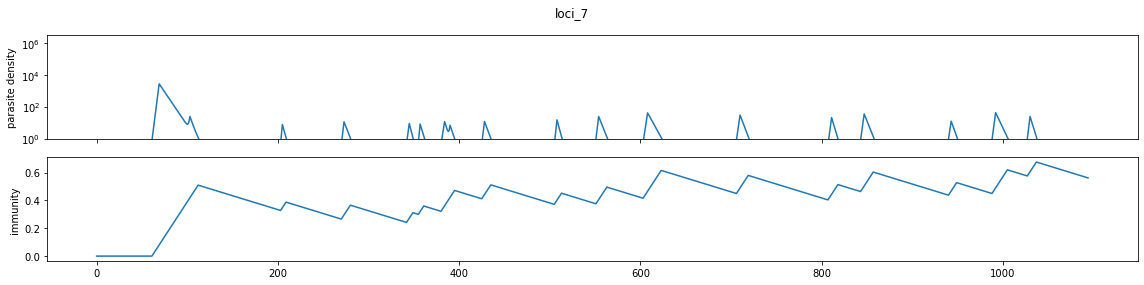

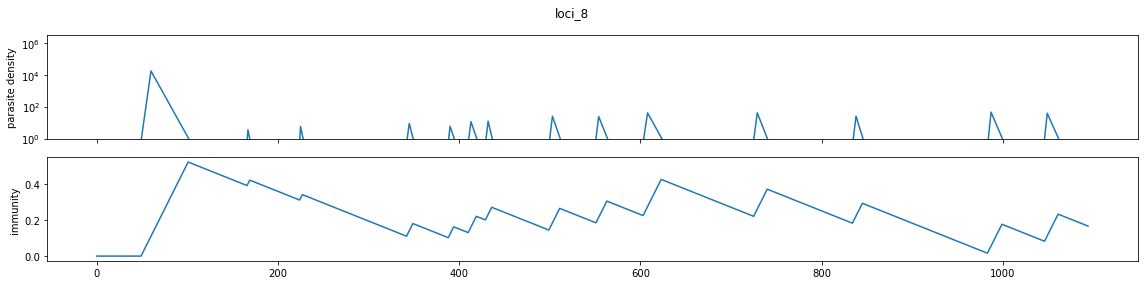

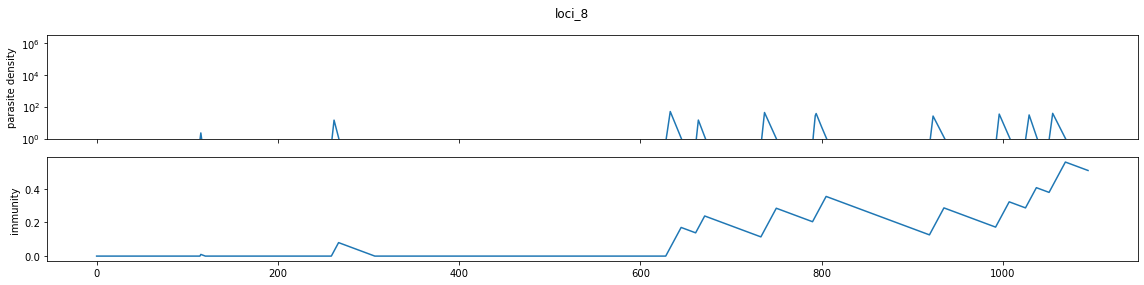

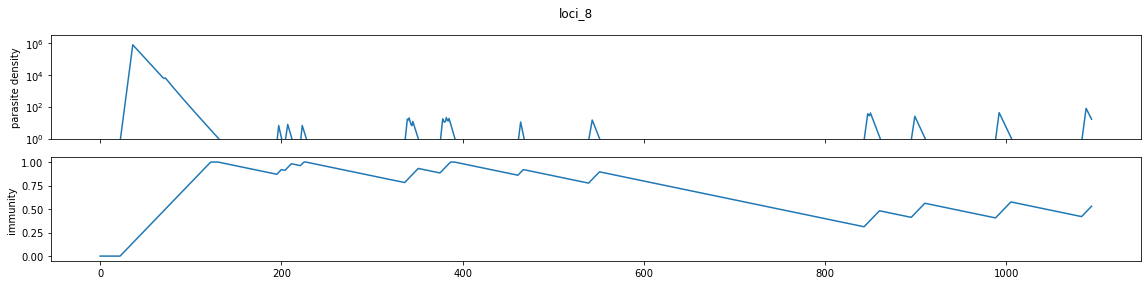

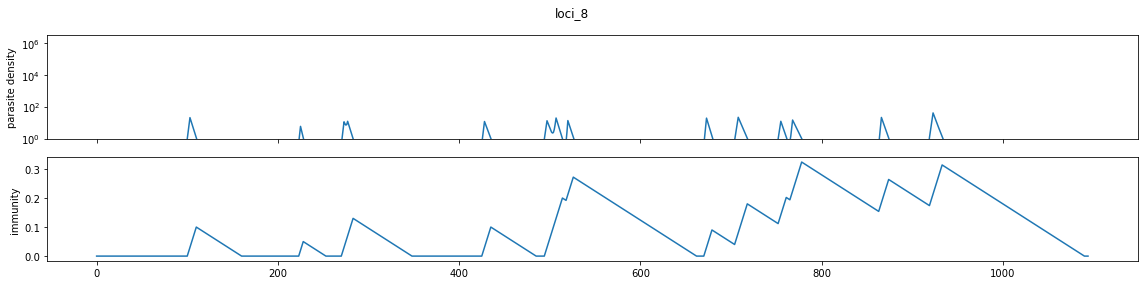

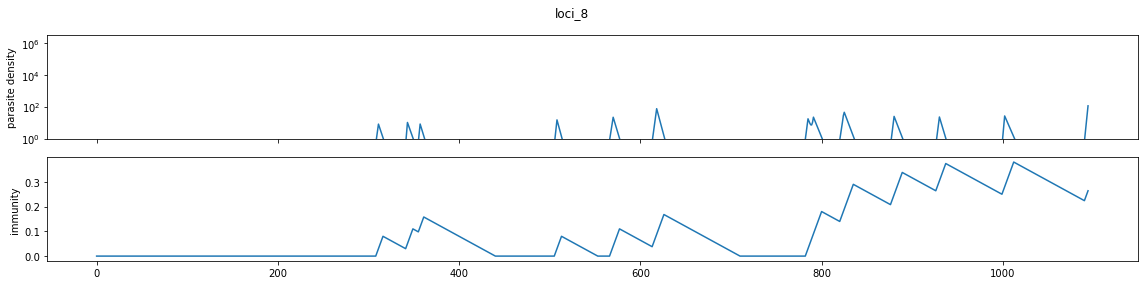

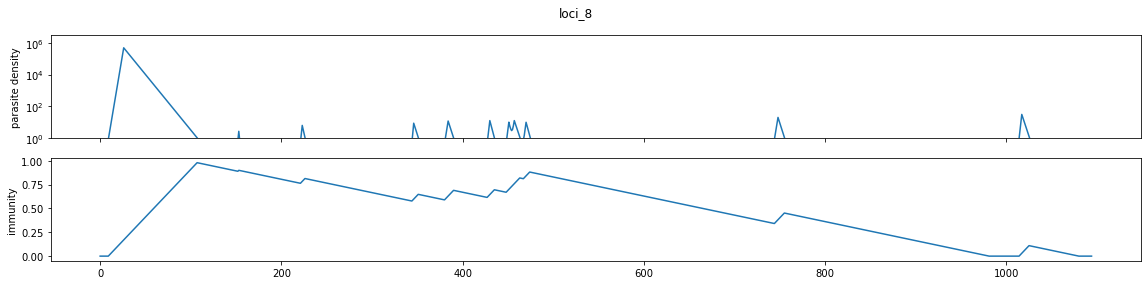

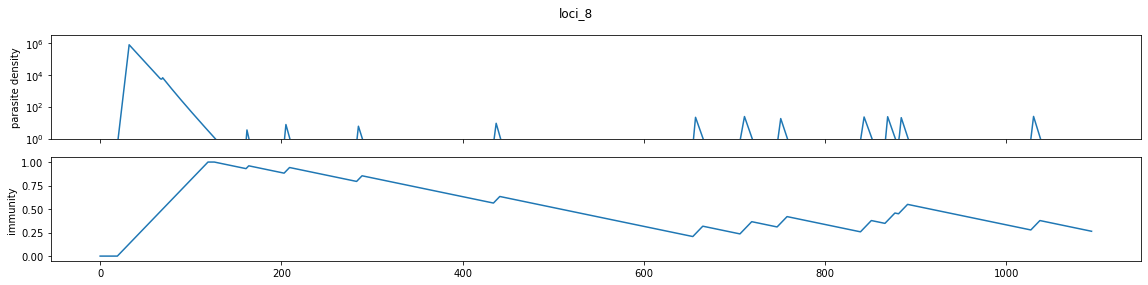

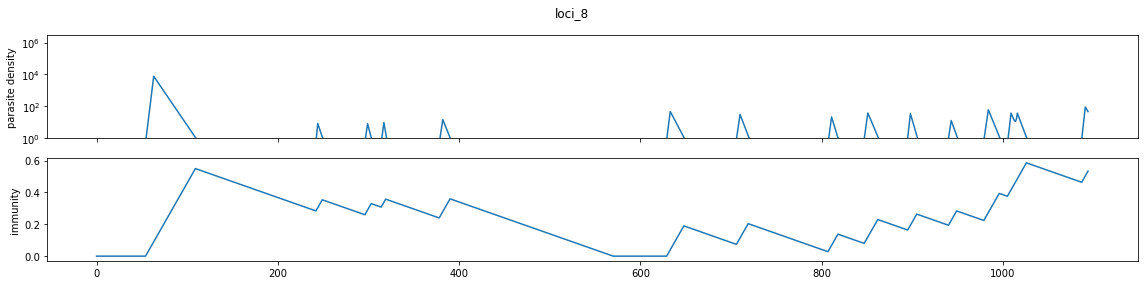

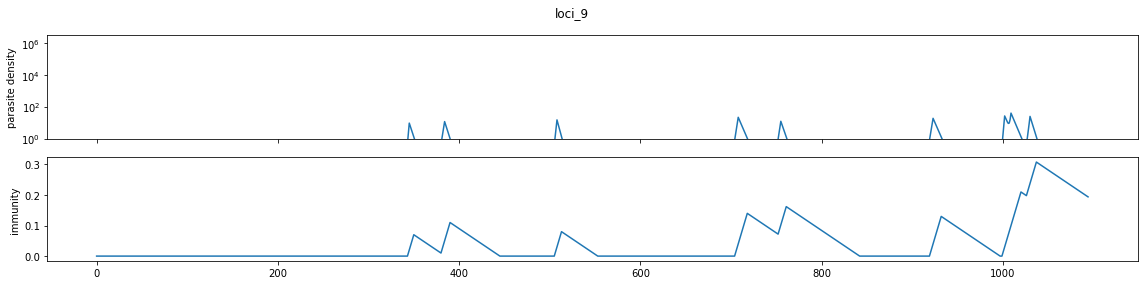

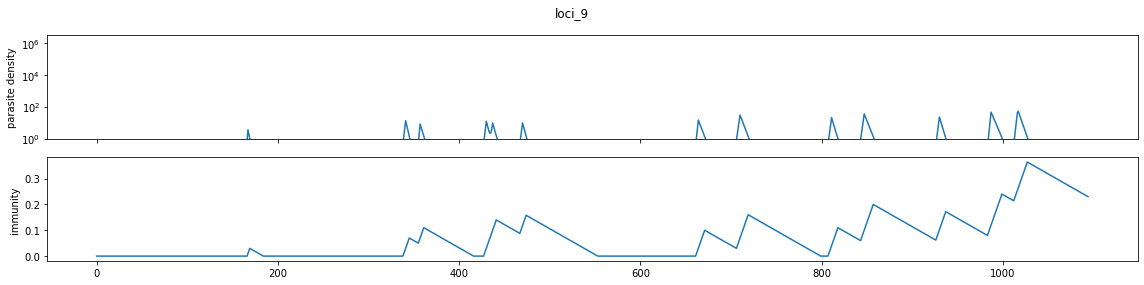

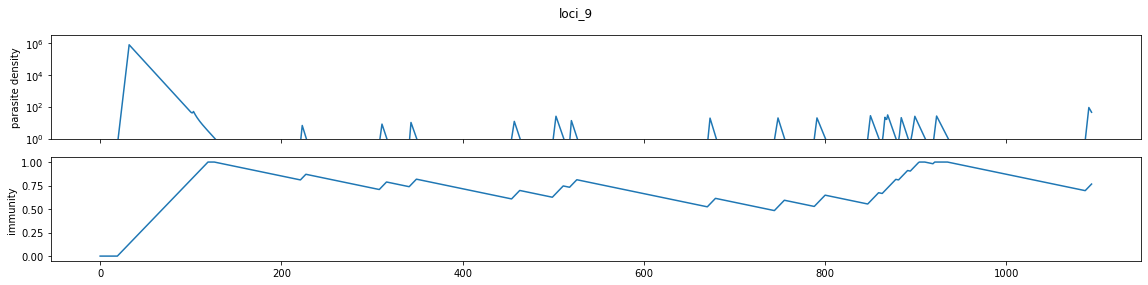

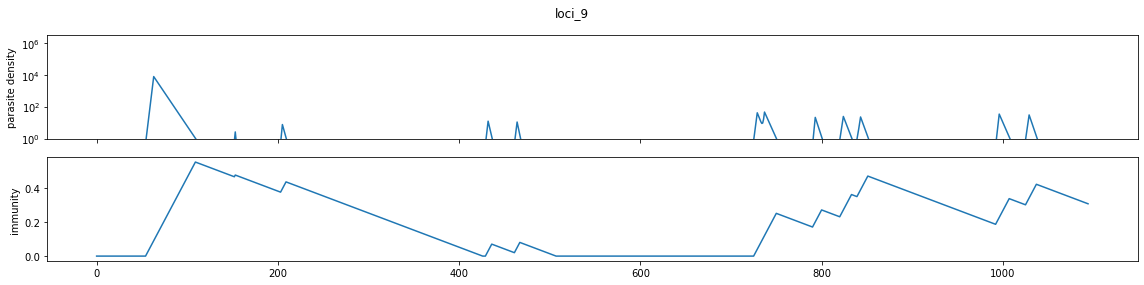

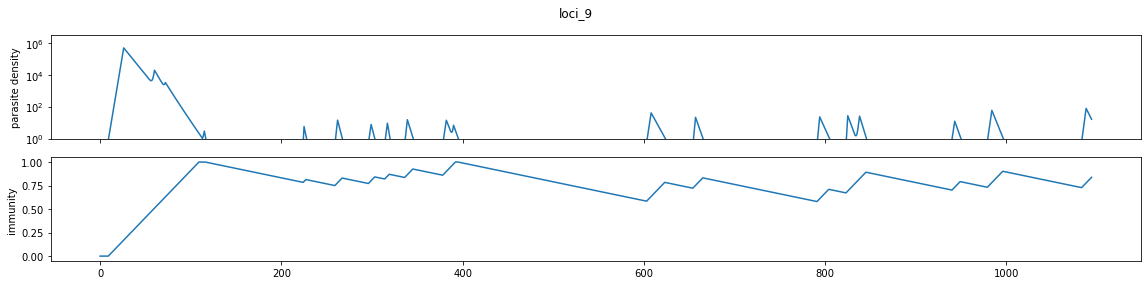

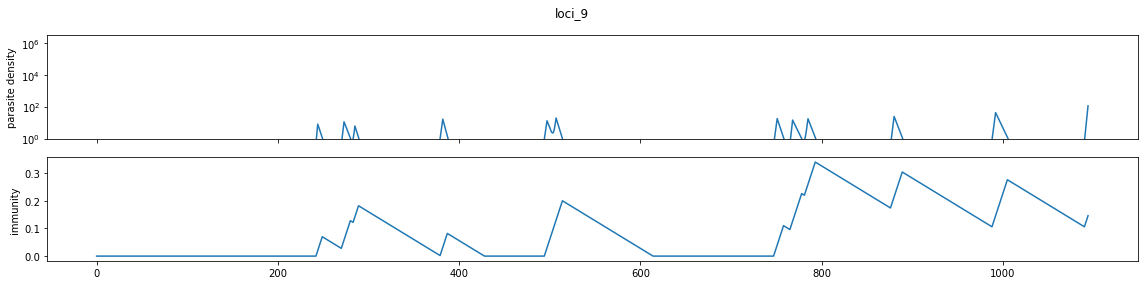

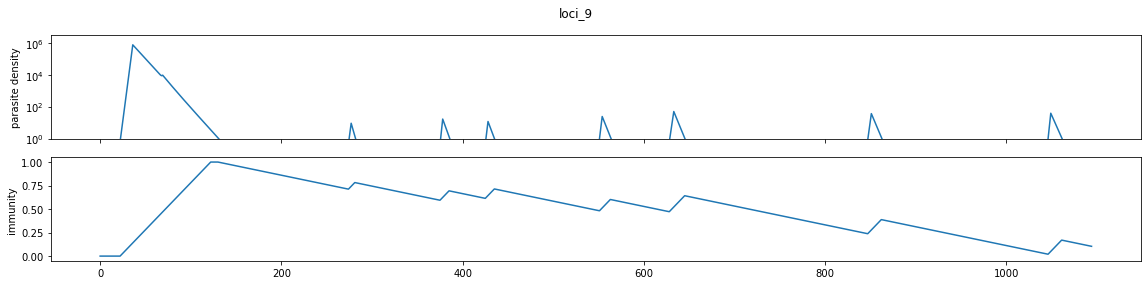

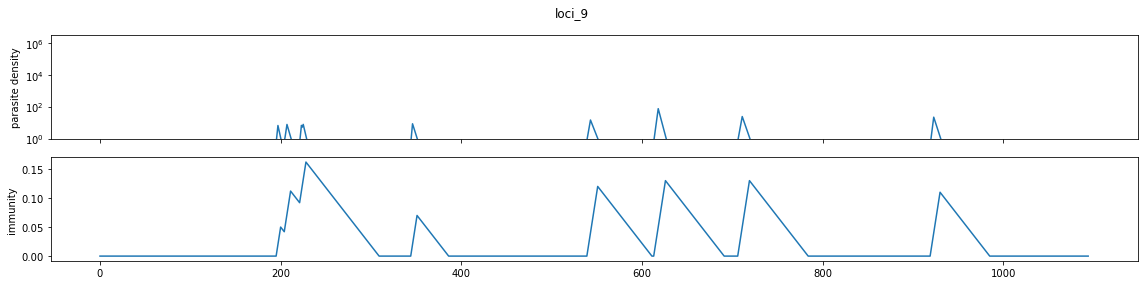

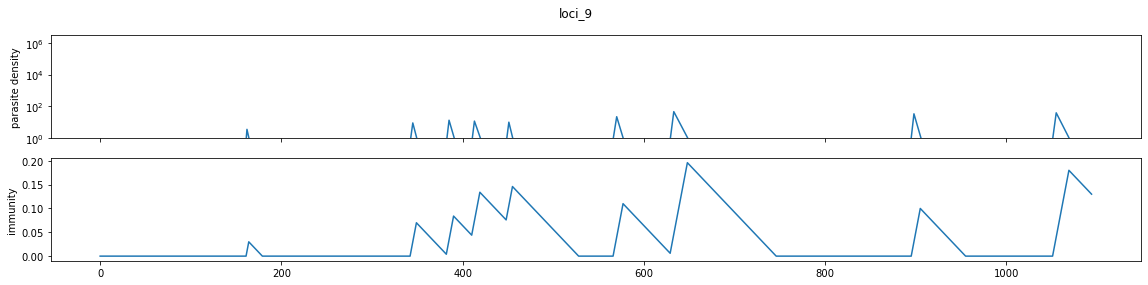

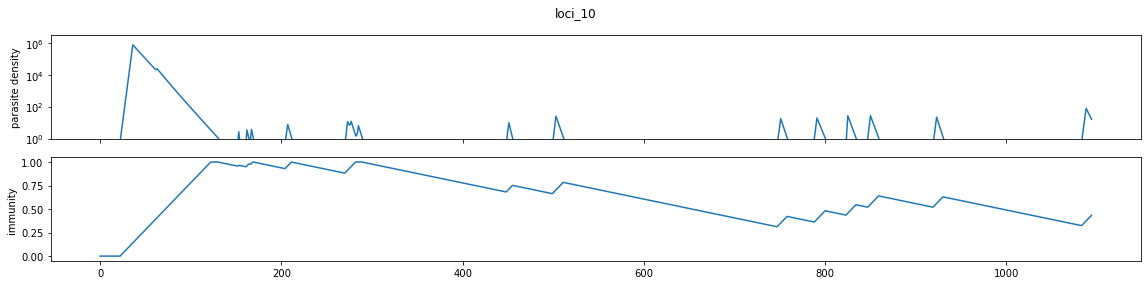

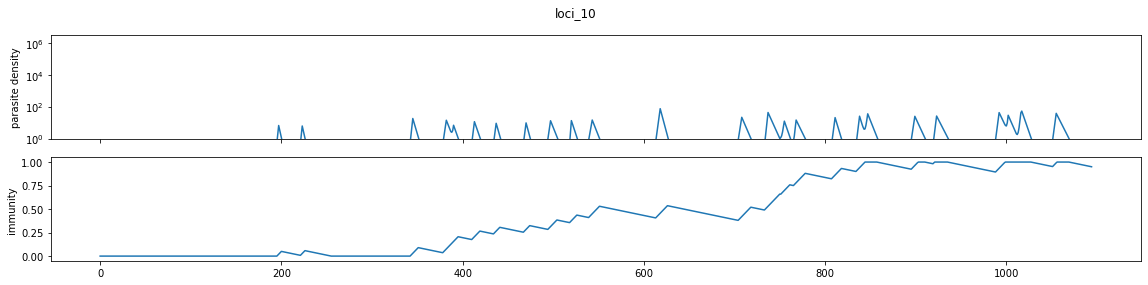

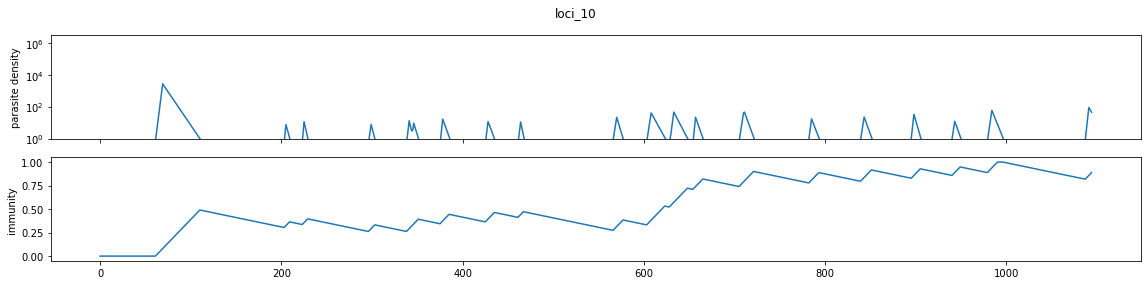

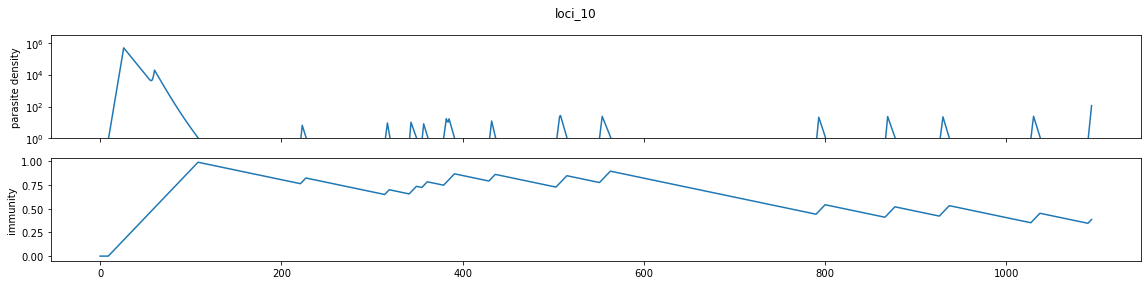

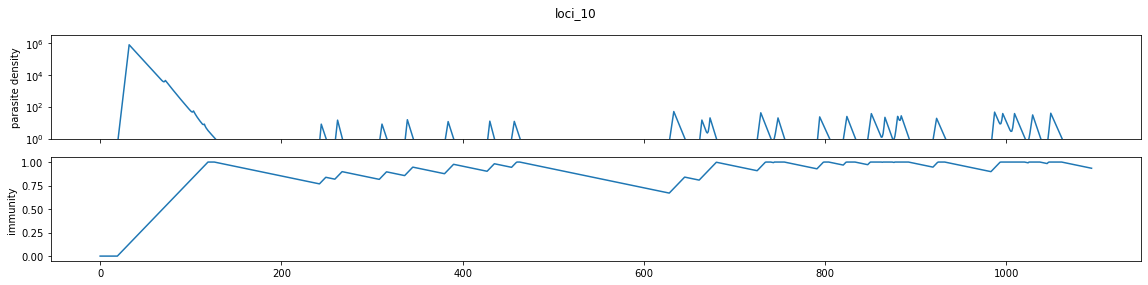

In [424]:
the_alleles = [3,4,6,5,5,6,5,7,8,9,5]

for j,k in enumerate(the_alleles):
    for i in range(k):
        fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = (16,4), tight_layout=True)
        ax[0].set_yscale('log')
        ax[0].plot(np.arange(3*365), pmatrix[j,i,:])
        ax[1].plot(np.arange(3*365), imatrix[j,i,:])
        ax[0].set_ylabel('parasite density')
        ax[1].set_ylabel('immunity')
        fig.suptitle('loci_' + str(j))
        ax[0].set_ylim(1,3000000)


In [ ]:
fig, ax = plt.subplots(figsize = (16,4), tight_layout=True)
ax.set_yscale('log')
ax.plot(np.arange(5*365), pmatrix[0,0,:], c = 'maroon')
ax.plot(np.arange(5*365), pmatrix[0,1,:], c = 'orangered')
ax.plot(np.arange(5*365), pmatrix[0,2,:], c = 'lightcoral')
ax.plot(np.arange(5*365), pmatrix[1,0,:], c = 'darkgreen')
ax.plot(np.arange(5*365), pmatrix[1,1,:], c = 'forestgreen')
ax.plot(np.arange(5*365), pmatrix[1,2,:], c = 'limegreen')
ax.plot(np.arange(5*365), pmatrix[1,3,:], c = 'springgreen')
ax.plot(np.arange(5*365), pmatrix[2,0,:], c = 'navy')
ax.plot(np.arange(5*365), pmatrix[2,1,:], c = 'blue')
ax.plot(np.arange(5*365), pmatrix[2,2,:], c = 'mediumslateblue')
ax.plot(np.arange(5*365), pmatrix[2,3,:], c = 'rebeccapurple')
ax.plot(np.arange(5*365), pmatrix[2,4,:], c = 'mediumorchid')
ax.plot(np.arange(5*365), pmatrix[2,5,:], c = 'plum')
#ax.set_ylim(1,100000)

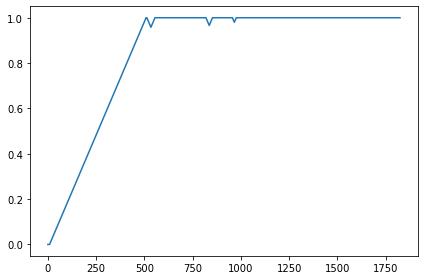

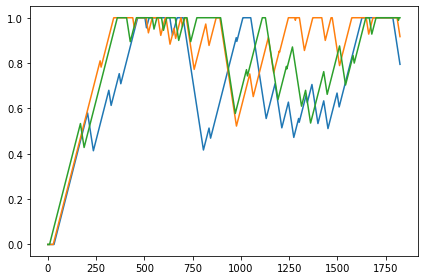

In [348]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.arange(5*365), imatrix[0,0,:])
ax.plot(np.arange(5*365), imatrix[0,1,:])
ax.plot(np.arange(5*365), imatrix[0,2,:])

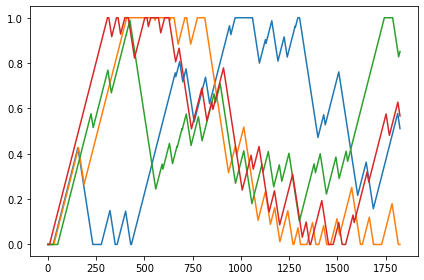

In [349]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.arange(5*365), imatrix[1,0,:])
ax.plot(np.arange(5*365), imatrix[1,1,:])
ax.plot(np.arange(5*365), imatrix[1,2,:])
ax.plot(np.arange(5*365), imatrix[1,3,:])

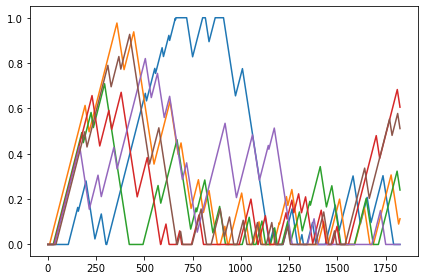

In [350]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.arange(5*365), imatrix[2,0,:])
ax.plot(np.arange(5*365), imatrix[2,1,:])
ax.plot(np.arange(5*365), imatrix[2,2,:])
ax.plot(np.arange(5*365), imatrix[2,3,:])
ax.plot(np.arange(5*365), imatrix[2,4,:])
ax.plot(np.arange(5*365), imatrix[2,5,:])

In [ ]:
for i in range(3):
    

fig, ax = plt.subplots(figsize = (16,4), tight_layout=True)
ax.set_yscale('log')
ax.plot(np.arange(5*365), pmatrix[0,0,:], c = 'maroon')
ax.plot(np.arange(5*365), pmatrix[0,1,:], c = 'orangered')
ax.plot(np.arange(5*365), pmatrix[0,2,:], c = 'lightcoral')
ax.plot(np.arange(5*365), pmatrix[1,0,:], c = 'darkgreen')
ax.plot(np.arange(5*365), pmatrix[1,1,:], c = 'forestgreen')
ax.plot(np.arange(5*365), pmatrix[1,2,:], c = 'limegreen')
ax.plot(np.arange(5*365), pmatrix[1,3,:], c = 'springgreen')
ax.plot(np.arange(5*365), pmatrix[2,0,:], c = 'navy')
ax.plot(np.arange(5*365), pmatrix[2,1,:], c = 'blue')
ax.plot(np.arange(5*365), pmatrix[2,2,:], c = 'mediumslateblue')
ax.plot(np.arange(5*365), pmatrix[2,3,:], c = 'rebeccapurple')
ax.plot(np.arange(5*365), pmatrix[2,4,:], c = 'mediumorchid')
ax.plot(np.arange(5*365), pmatrix[2,5,:], c = 'plum')
#ax.set_ylim(1,100000)

Next I'm going to add treatment....

In [518]:
def treat_as_needed(thresh, pM, sM, t, m):
    '''
    Treat if parasitemia goes above certain threshold
    '''
    threshhold = st.lognorm.rvs(s=0.4,scale=thresh)
    if pM[0,:,t].sum(axis=0) > threshhold:
        pM[:,:,t:] = 0
        sM[:,t:] = 0
        m += 1 
    return m

In [655]:
np.log10(0.01)

-2.0

-230772.70475431453
-218.2848370385742
188483.80816644194


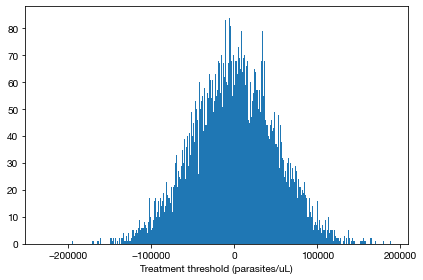

In [77]:
M = np.empty(10000)
for i in range(10000):
    M[i] = st.norm.rvs(loc,scale=100)

fig, ax = plt.subplots(tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
ax.hist(M[:],bins=500)
ax.set_xlabel('Treatment threshold (parasites/uL)')
print(min(M))
print(np.median(M))
print(max(M))

In [86]:
temp = np.load("../../isabel-elife-immunity/output/fever/matrix.npy")
age_breaks = np.load("../../isabel-elife-immunity/output/fever/age.npy")
pardens_breaks = np.load("../../isabel-elife-immunity/output/fever/pardens.npy")
eir_breaks = np.load("../../isabel-elife-immunity/output/fever/eir.npy")
#temp = temp.reshape((40,40,40))
fever = (temp >= 38)*1

In [90]:
np.nonzero(fever[0,:,:])

(array([19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
        24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 

In [119]:
    age_loc = np.flatnonzero(breaks[:,0]>=t/365)[0]
    eir_loc = np.flatnonzero(breaks[:,2]>=eir)[0]
    pardens_loc = np.flatnonzero(fever[age_loc,:,eir_loc])[0]

In [120]:
pardens_loc

26

In [123]:
get_fever_threshold(10,40)

8576.958985908937

In [93]:
def get_fever_threshold(t, eir):
    age_loc = np.flatnonzero(age_breaks[age_breaks>=t/365])[0]
    eir_loc = np.flatnonzero(eir_breaks>=eir)[0]
    pardens_loc = np.flatnonzero(fever[age_loc,:,eir_loc])[0]
    thresh = pardens_breaks[pardens_loc]
    return 10**thresh

In [10]:
def load_data():
    '''
    Loads data used in the model
    '''
    fever = np.load("data/fever.npy")
    breaks = np.load("data/breaks.npy")
    return fever, breaks
    
def simulate_bites(y,eir):
    '''
    Produces a vector with bite times up until year, y, is reached.

    Time between bites pulled from exponential distribution wih mean rate of k.
    '''
    k = eir/365
    n = round(y*eir*2)
    spaces = st.expon.rvs(scale=(1/k), loc=0, size=n)
    times = np.cumsum(spaces)
    trimmed = times[times <= y*365]
    bites = np.ceil(trimmed).astype(int)
    return bites

def simulate_strains(n,a):
    '''
    n = number of strains to simulate
    a = vector containing whose length corresponds to number of loci.
    Each entry correpsonds to the number of alleles at that loci.
    so a = [3,4,6] will simulate a strain with 3 loci. The first
    loci has 3 alleles; the second loci has 4 alleles, and the third
    loci has 6 alleles.
    
    Returns genotype as a L x n matrix, where L = the number of loci.
    '''
    length = len(a)
    M = np.empty((length,n),dtype=int)
    for i in range(n):
        floats = np.random.rand(length)
        genotype = np.ceil(floats*a)-1
        M[:,i] = genotype
    return M

def create_allele_matrix(a,y):
    '''
    Creates matrix to track parasitemia.
    '''
    length = len(a)
    width = max(a)
    days = 365*y
    M = np.zeros((length,width,days))
    return M

def create_gen_imm(y):
    '''
    creates vector for immunity of lenth y *365
    '''
    immunity = np.zeros(y*365)
    return immunity

def get_infection_params(duration, meroz, timeToPeak, maxParasitemia):
    '''
    Generates the duration of infection a geometric distribution.
    Generates starting number of merozoites from a normal distribution.
    Generates time to peak from a distribution.
    Generates parasite max from a distribution.
    '''
    #dur = st.geom.rvs(1/200) #This is resulting in way too much variability
    dur = np.rint(st.norm.rvs(loc=duration,scale=20))
    mz = st.lognorm.rvs(s=.5,scale=meroz)
    peaktime = np.rint(st.norm.rvs(loc=timeToPeak, scale=3)) # Unsure what kind of distribution to use here. Maybe log normal? They use log normal distribution for time to peak. Maybe because it can't be negative.
    #peaktime = st.geom.rvs(1/20)
    pmax = st.norm.rvs(loc=maxParasitemia,scale=0.25) # PfLOME uses normal distribution but it stores this variable in log, so I'm going to use a lognormal distribution.
    params = np.array([dur, mz, peaktime, pmax])
    return params

def get_parasitemia(params, pgone):
    '''
    Creates parasitemia values distributed according
    to params & adds to parasitemia matrix.
    '''
    dur = params[0].astype(int)
    mz = np.log10(params[1])
    peaktime = params[2].astype(int)
    pmax = params[3]
    gr = (pmax - mz)/peaktime
    dr = (pgone - pmax) / (dur - peaktime - 1)
    arr = np.zeros(dur)
    arr[0] = mz
    for i in np.arange(1,peaktime+1):
        arr[i] = arr[i-1] + gr
    for i in np.arange(peaktime+1,dur):
        arr[i] = arr[i-1] + dr
    return arr

def create_strain_matrix(n,y):
    M = np.zeros((n,y*365),dtype=int)
    return M

def add_infection(p,gtype,pM,sM,t,i):
    dur = len(p)
    days = pM.shape[2]
    n_alleles = len(gtype)
    for j in np.arange(n_alleles):
        if t+dur >= days:
            dur = days-t
            p = p[:dur]
        pM[j,gtype[j],t:t+dur] += 10**p
        sM[i,t:t+dur] = 1

def sigmoid(x,p):
    a = np.tan(np.pi/2*xh)**b
    result = p/(a/np.tan(np.pi/2*x)**b+1)
    return result

def modulate_params(gen_imm, strain_imm, gtype, w, params):
    '''
    Changes infection params according to immunity
    '''
    n_loci = len(gtype)
    cross = np.empty(n_loci)
    for i in np.arange(n_loci):
        allele = gtype[i]
        cross[i] = strain_imm[i,allele]
    imm = np.append(gen_imm, cross)
    
    M = np.zeros((4, n_loci+1))
    for i, p in enumerate(params):
        for j, v in enumerate(imm):
            if v == 0 | i == 2:
                M[i,j] = p*w[j]
            else:
                M[i,j] = sigmoid(v, p*w[j])
    modified = np.zeros(4)
    for i in np.arange(4):
        modified[i] = M[i,:].sum()
    modified[0] = np.rint(modified[0])
    modified[2] = np.rint(modified[2])
    return modified

def update_immunity(parasites,t,imm,M,immune_thresh, alpha=alpha,beta=beta,gamma=gamma,delta=delta,):
    '''
    If parasitemia present gains immunity. If absent, loses immunity.
    '''
    # General immunity
    
    if parasites[0,:,t].sum(axis=0) > immune_thresh:
        if t == 0:
            imm[t] = alpha
        else:
            imm[t] = min(imm[t-1] + alpha,1)
    else:
        if t == 0:
            imm[t] = 0
        else:
            imm[t] = max(imm[t-1] - beta, 0)
        
    # Strain immunity
    loci = parasites.shape[0]
    n_alleles = parasites.shape[1]
    for i in np.arange(loci):
        for j in np.arange(n_alleles):
            if parasites[i,j,t] > immune_thresh:
                M[i,j,t] = 1
                #if t == 0:
                 #   M[i,j,t] = gamma
                #else:
                 #   M[i,j,t] = min(M[i,j,t-1] + gamma,1)
            else:
                if t == 0:
                    M[i,j,t] = 0
                else:
                    M[i,j,t] = max(M[i,j,t-1] - delta, 0)
                    
def get_fever_threshold(t, eir,fever,breaks):
    '''
    Pulls fever threshold from model used in ["Quantification of anti-parasite and anti-disease immunity to malaria as a function of age and exposure"](https://elifesciences.org/articles/35832).
    '''
    age_loc = np.flatnonzero(breaks[:,0]>=t/365)[0]
    eir_loc = np.flatnonzero(breaks[:,2]>=eir)[0]
    pardens_loc = np.flatnonzero(fever[age_loc,:,eir_loc])[0]
    thresh = breaks[pardens_loc,1]
    return 10**thresh
                    
def treat_as_needed(threshhold, pM, sM, t, m):
    '''
    Treat if parasitemia goes above certain threshold. Modifies parasite density
    matrix & strain matrix. Returns number of malaria cases thus far in
    individual's life:
        treatment_thresh = threshold for treatment
        pM = matrix tracking parasite density per allele across time.
        sM = matrix tracking presence of strains across time.
        t = time
        m = # of malaria cases that have occurred
    '''
    #threshhold = st.lognorm.rvs(s=0.4,scale=treatment_thresh)
    if pM[0,:,t].sum(axis=0) > threshhold:
        pM[:,:,t+1:] = 0
        sM[:,t+1:] = 0
        m.append(t)
    return m
        
def check_moi(y,sM):
    mois = []
    for t in range(0,y*365,30):
        moi = sM[:,t].sum()
        mois.append(moi)
    return mois

def check_parasitemia(y,pM,dthresh):
    pdensity = []
    ppositivity = []
    for t in range(0,y*365,30):
        p = pM[0,:,t].sum()
        pdensity.append(p)
        if p > dthresh:
            ppositivity.append(1)
        else:
            ppositivity.append(0)
    perpos = np.average(ppositivity)
    return pdensity, perpos

def check_infection_length(sM,y, malaria):
    lengths = []
    infections = len(sM)
    for i in range(infections):
        counter = 0
        for j in range(y*365):
            if sM[i,j] == 1:
                counter += 1
                if j in malaria:
                    counter = 0
        if counter > 0:
            lengths.append(counter)
    return lengths



In [11]:
n_people = 100
y=5

weight = [0,.2,.1,.1,.15,.1,.05,.1,.07,.03,.1,0]
the_alleles = [3,4,6,5,5,6,5,7,8,9,5]

alpha = 1/500
beta = 1/500
gamma = 1/25
delta = 1/250

eir = 40

duration = 500
meroz = 0.01
timeToPeak = 10
maxParasitemia = 6 # log10 scale

xh = 0.5
b = -1

#treatment_thresh = 100000
pgone = -3 # log10 scale scale
immune_thresh = 0.01 # standard scale
detect_thresh = 0.001

fever,breaks = load_data()

In [12]:
breaks

array([[  0.5       ,   1.        ,   1.4       ],
       [  0.76923077,   1.13333333,   1.61292316],
       [  1.03846154,   1.26666667,   1.85822936],
       [  1.30769231,   1.4       ,   2.14084369],
       [  1.57692308,   1.53333333,   2.46644026],
       [  1.84615385,   1.66666667,   2.84155615],
       [  2.11538462,   1.8       ,   3.27372265],
       [  2.38461538,   1.93333333,   3.77161648],
       [  2.65384615,   2.06666667,   4.34523397],
       [  2.92307692,   2.2       ,   5.00609177],
       [  3.19230769,   2.33333333,   5.7674581 ],
       [  3.46153846,   2.46666667,   6.64461909],
       [  3.73076923,   2.6       ,   7.65518571],
       [  4.        ,   2.73333333,   8.81944735],
       [  4.26923077,   2.86666667,  10.16077918],
       [  4.53846154,   3.        ,  11.70611145],
       [  4.80769231,   3.13333333,  13.48647015],
       [  5.07692308,   3.26666667,  15.5376    ],
       [  5.34615385,   3.4       ,  17.90068203],
       [  5.61538462,   3.53333

In [13]:
all_n_bites = []
all_parasites = np.zeros((n_people, len(the_alleles), max(the_alleles), y*365))
all_strain_immunity = np.zeros((n_people, len(the_alleles), max(the_alleles), y*365))
all_gen_immunity = np.zeros((n_people,y*365))
all_parasite_density = []
all_infection_lengths = []
all_MOI = []
all_percent_parasitemia = []
all_malaria_rate = []


for person in range(n_people):
    malaria = []
    bites = simulate_bites(y,eir)
    n_bites = len(bites)
    strains = simulate_strains(n_bites,the_alleles)
    pmatrix = create_allele_matrix(the_alleles, y)
    smatrix = create_strain_matrix(n_bites,y)
    imatrix = create_allele_matrix(the_alleles,y)
    ivector = create_gen_imm(y)

    counter = 0
    for t in range(365*y):
        update_immunity(pmatrix,t,ivector,imatrix, immune_thresh, alpha, beta, gamma, delta)
        thresh = get_fever_threshold(t,eir,fever,breaks)
        malaria = treat_as_needed(thresh,pmatrix,smatrix,t,malaria)
        if t in bites:
            if not len(malaria)> 0 or t - malaria[-1] > 7:
                locs = np.where(bites == t)
                for i in locs[0]:
                    params = get_infection_params(duration, meroz, timeToPeak, maxParasitemia)
                    params = modulate_params(ivector[t], imatrix[:,:,t], strains[:,i], weight, params)
                    if params[0] > 0 and params[3] > 0 and params[1] > 0.001 and params[0] > params[2]:
                        parasitemia = get_parasitemia(params, pgone)
                        add_infection(parasitemia,strains[:,i],pmatrix,smatrix,t,i)

    Parasitemia, perPositivity = check_parasitemia(3,pmatrix,detect_thresh)
    MOI = check_moi(3,smatrix)
    infectionlengths = check_infection_length(smatrix,y,malaria)
    malaria_per_year = len(malaria)/y
    
    all_n_bites.append(n_bites/y)
    all_parasites[person,:,:,:] = pmatrix
    all_strain_immunity[person,:,:,:] = imatrix
    all_gen_immunity[person,:] = ivector
    all_parasite_density.extend(Parasitemia)
    all_infection_lengths.extend(infectionlengths)
    all_MOI.extend(MOI)
    all_percent_parasitemia.append(perPositivity)
    all_malaria_rate.append(malaria_per_year)

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_15616/1544210514.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  result = p/(a/np.tan(np.pi/2*x)**b+1)
/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_15616/1544210514.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  gr = (pmax - mz)/peaktime


0.8
Bites per year
min:32.2
max:45.8
median:39.9
mean:39.785999999999994
std:2.6439750377036466
---------------------
Parasite density
min:0.0
max:65065.38079656458
median:5.420859785676654
mean:120.22296592577123
std:1285.0639252937158
---------------------
Infection length
min:1
max:345
median:79.0
mean:86.15337140751659
std:42.19368310032881
---------------------
MOI
min:0
max:12
median:5.0
mean:5.034054054054054
std:2.2897957650687557
---------------------
% Parasitemia
min:0.8648648648648649
max:0.972972972972973
median:0.9459459459459459
mean:0.9445945945945947
std:0.02367758847018275
---------------------
Malaria cases per year
min:0.2
max:0.8
median:0.4
mean:0.42399999999999993
std:0.1477294825009551
---------------------


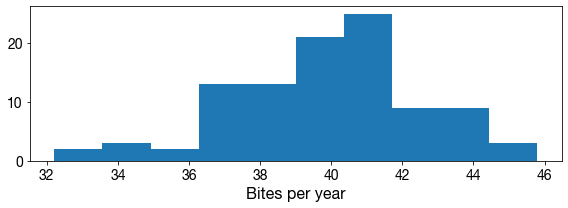

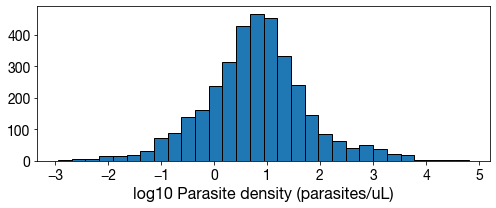

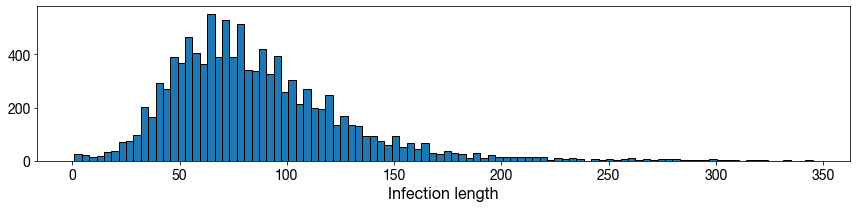

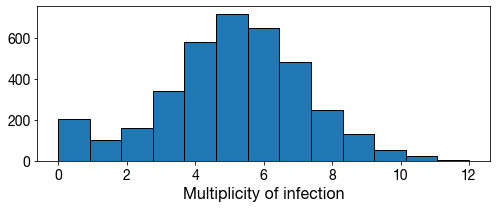

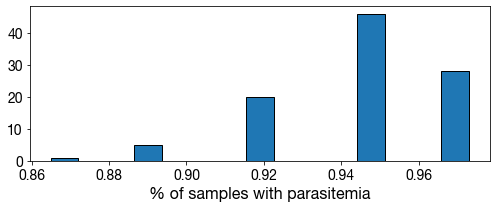

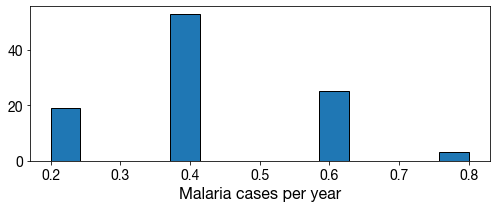

In [14]:
fig,ax = plt.subplots(tight_layout=True, figsize=(8,3))
ax.tick_params(axis='both', which='major', labelsize=14)
#ax.tick_params(axis='both', which='minor', labelsize=8)
ax.hist(all_n_bites, bins=10)
ax.set_xlabel('Bites per year',fontsize=16)


all_parasite_density = np.asarray(all_parasite_density)
logPdensity = np.log10(all_parasite_density[all_parasite_density != 0])
fig,ax = plt.subplots(tight_layout=True, figsize=(7,3))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.hist(logPdensity,bins=30,edgecolor='black')
ax.set_xlabel('log10 Parasite density (parasites/uL)',fontsize=16)
#ax.set_yscale('log')
#fig.savefig("../../../../../Downloads/pdense.png")

fig,ax = plt.subplots(tight_layout=True, figsize=(12,3))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.hist(all_infection_lengths, bins=100,edgecolor='black')
ax.set_xlabel('Infection length',fontsize=16)
#fig.savefig("../../../../../Downloads/length.png")

fig,ax = plt.subplots(tight_layout=True, figsize=(7,3))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.hist(all_MOI, bins=(max(all_MOI)+1),edgecolor='black')
ax.set_xlabel('Multiplicity of infection',fontsize=16)
#fig.savefig("../../../../../Downloads/moi.png")

fig,ax = plt.subplots(tight_layout=True, figsize=(7,3))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.hist(all_percent_parasitemia, bins=15,edgecolor='black')
ax.set_xlabel('% of samples with parasitemia',fontsize=16)
#fig.savefig("../../../../../Downloads/para.png")

print(max(all_malaria_rate))
fig,ax = plt.subplots(tight_layout=True, figsize=(7,3))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.hist(all_malaria_rate, bins=14,edgecolor='black')
ax.set_xlabel('Malaria cases per year',fontsize=16)
#fig.savefig("../../../../../Downloads/malaria.png")

results = [all_n_bites, all_parasite_density, all_infection_lengths, all_MOI, all_percent_parasitemia, all_malaria_rate]
labels = ['Bites per year', 'Parasite density', 'Infection length', 'MOI', '% Parasitemia', 'Malaria cases per year']

for values, l in zip(results, labels):
    print(l)
    print('min:' + str(min(values)))
    print('max:' + str(max(values)))
    print('median:' + str(np.median(values)))
    print('mean:' + str(np.average(values)))
    print('std:' + str(np.std(values)))
    print('---------------------')

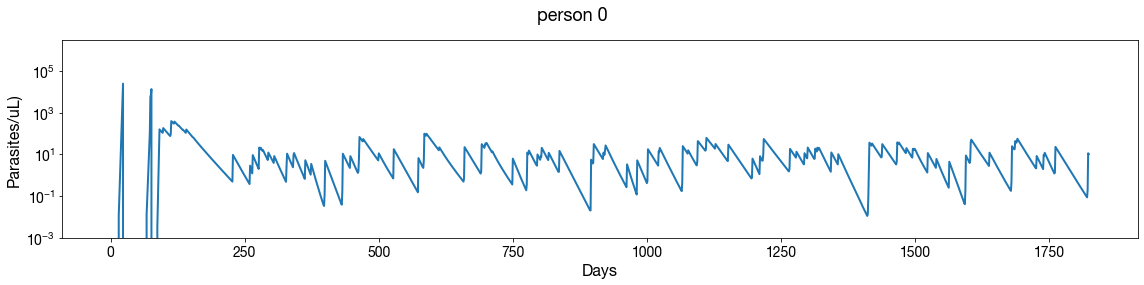

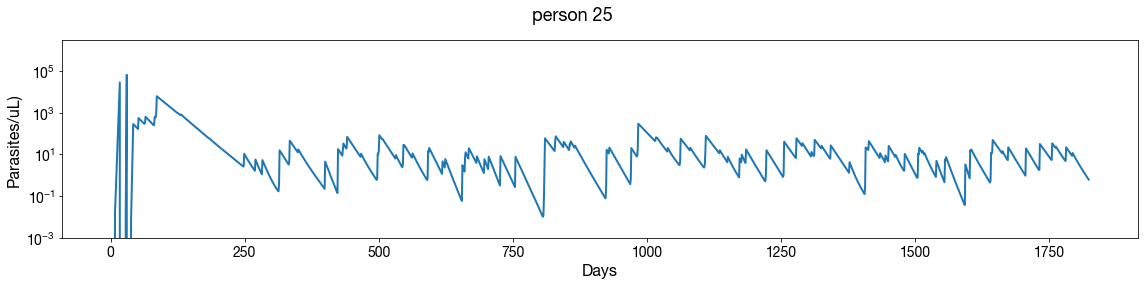

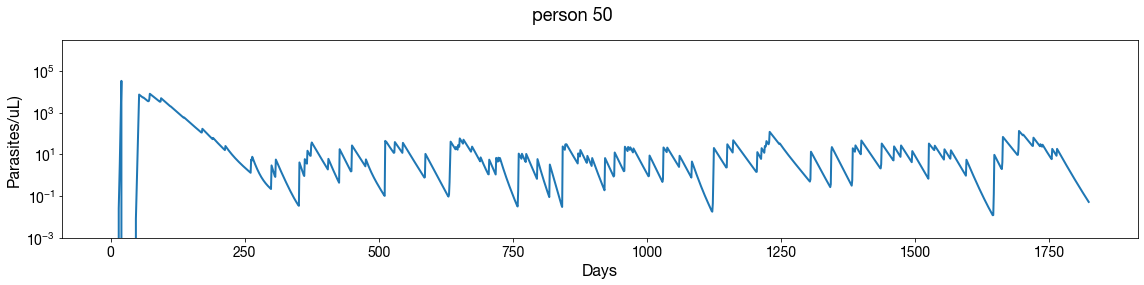

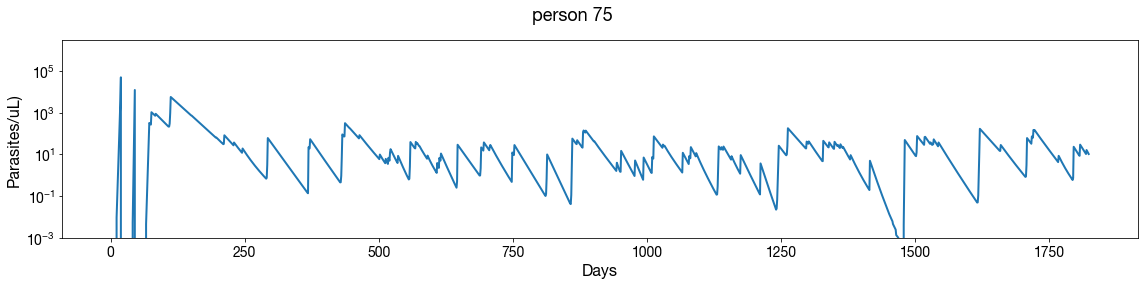

In [15]:
for i in range(0,n_people,25):
    fig, ax = plt.subplots(tight_layout=True, figsize=(16,4))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_yscale('log')
    ax.plot(np.arange(y*365), all_parasites[i,0,:,:].sum(axis=0), linewidth=2)
    ax.set_ylim(0.001,3000000)
    #ax.set_xlim(0,30)
    fig.suptitle('person ' + str(i), fontsize=18)
    ax.set_xlabel('Days', fontsize=16)
    ax.set_ylabel('Parasites/uL)',fontsize=16)
    #fig.savefig('../../../../../Downloads/record'+str(i) + '.png')

In [723]:
all_parasites[5,0:3,0:6,500].astype(int)

array([[ 298, 1323,  996,    0,    0,    0],
       [ 285, 1251,  671,  409,    0,    0],
       [   0, 1080,    0, 1199,    0,  337]])

In [73]:
pmatrix

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [724]:
all_strain_immunity[5,0:3,0:6,500]

array([[1.   , 1.   , 1.   , 0.   , 0.   , 0.   ],
       [0.736, 1.   , 1.   , 0.6  , 0.   , 0.   ],
       [0.   , 1.   , 0.228, 1.   , 0.   , 1.   ]])

In [725]:
all_gen_immunity[5,500]

0.20600000000000016